********
### Physics-informed Seismic Response Prediction using deep 1D CNN  compiled in Extended State Space Fusion
********
#### by Qingsong Xiong 2022.11.26
#### Email-address: 2011158@tongji.edu.cn

# PART A: Numerical study on MSDS

## 1 Load seismic ground motion record

A suite of earthquake records selected from the PEER strong motion database

In [1]:
import pandas as pd
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

In [ ]:
#concatenate individual ground motions into integrated file
# import pandas as pd
# import os

# path= 'D:/research work/Pyhsical multi-channel 1D CNN/data/ATC-63 Record Set/Far-Fied Record/'
# filelist=os.listdir(path)
# N=len(filelist)

# data_df=pd.read_table(path+filelist[0],header=None,delim_whitespace=True,skiprows=6,nrows=3600)
# for i in range (N-1):
#     temp =pd.read_table(path+filelist[i+1],header=None,delim_whitespace=True,skiprows=6,nrows=3600)
#     data_df=pd.concat([data_df, temp], axis=1)
#     i+=1
    

In [ ]:
# data_df.shape

In [ ]:
# dataframe 格式转为csv，后在进行读取
csvpath= 'D:/research work/Pyhsical SSM-CNN/data/'
# data_df.to_csv(csvpath+'data.csv',  header=None, index_label=None,index=None)

In [ ]:
data1= pd.read_csv(csvpath+'data.csv',header=None)
print(data1.shape)

In [ ]:
data=data1.values
print(data.shape)

In [ ]:
# random pick two ground motions to depict
plt.rc('font',family='Times New Roman')
fig = plt.figure(figsize=(8, 2), dpi=300)
plt.subplots_adjust( wspace=0.25, hspace=None)

plt.subplot(1,2,1)
plt.plot(data[:,0], linewidth=0.9)
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')

plt.subplot(1,2,2)
plt.plot(data[:,7], linewidth=0.9)
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')

## 2 State Space Model 

### 2.1 Numerical simulation of MSDS

In [ ]:
#parameter defining the system
c=2 #damping
k=5 #stiffness
m=20

In [ ]:
# Fs=np.ones(600)*5 #numeircal loading 

In [ ]:
# simulation timespace
tstart=0
tstop=360
increment=0.1
t=np.arange(tstart,tstop,increment)

In [ ]:
#system matrices
A=[[0,1],[-k/m,-c/m]]
B=[[0],[1/m]]
C=[[1,0]]
sys=sig.StateSpace(A,B,C,0)

In [ ]:
Ft=data[:,0] #random define a input earthquake record

In [ ]:
#step response for the system 
t,y,x=sig.lsim(sys,Ft,t)
x1=x[:,0]  #position/displacement
x2=x[:,1] #velocity

In [ ]:
# calculate acceleration to build Extended State Space Model (ESSM)
dt=0.1 #time increment
L=len(x1)-1
x3=np.zeros(shape=(L+1,1)) 
x3[0,]=0
x3[L,]=(x1[L,]-x1[L-1,]-dt*x2[L,])*2/(dt*dt)
## loop without the beginning and ending one
for i in range (L-2):
    x3[i+1,]=(x1[i+2,]-x1[i,]-2*dt*x2[i,])/(dt*dt)
    i+=1
print(x3.shape)

In [ ]:
fig = plt.figure(figsize=(7, 3), dpi=150)
plt.rc('font',family='Times New Roman')
plt.plot(t,x1,label='displacement (m)')
plt.plot(t,x2,label='velocity (m/s)')
plt.plot(t,x3,label='acceleration (m/$\mathregular{s^2}$)',linestyle='--', linewidth=1,color='g',)
plt.title('Simualtion of MSDS under seismic loading')
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('State space value',fontsize=12,weight='normal')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# State trajectory
fig = plt.figure(figsize=(8, 7), dpi=150)
plt.rc('font',family='Times New Roman')
plt.suptitle('Simualtion State trajectory of MSDS under recorded seismic loading',y=0.92)
plt.subplots_adjust( wspace=0.3, hspace=0.3)

plt.subplot(2,2,1)
plt.plot(x1,x2)
plt.title("(a)",x=0.9,y=0.9,weight='bold')
plt.xlabel('Displacement (m)',fontsize=12,weight='normal')
plt.ylabel('Velocity (m/s)',fontsize=12,weight='normal')
plt.grid(color='g', linestyle='--', linewidth=0.5,alpha=0.5)

plt.subplot(2,2,2)
plt.plot(x2,x3)
plt.title("(b)",x=0.9,y=0.9,weight='bold')
plt.xlabel('Velocity (m/s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')
plt.grid(color='g', linestyle='--', linewidth=0.5,alpha=0.5)

plt.subplot(2,2,3)
plt.plot(x3,x1)
plt.title("(c)",x=0.9,y=0.9,weight='bold')
plt.ylabel('Displacement (m)',fontsize=12,weight='normal')
plt.xlabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')
plt.grid(color='g', linestyle='--', linewidth=0.5,alpha=0.5)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter3D(x1, x2, x3,marker='.')
ax.set_title("(d)",x=0.9,y=1,weight='bold')
ax.set_xlabel('Displacement (m)',fontsize=12,weight='normal')
ax.set_ylabel('Velocity (m/s)',fontsize=12,weight='normal')
ax.set_zlabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal');


### 2.2 Activated by seismic record

Data augmentation: add noise to the input seismic force

In [ ]:
def wgn(x,snr):
    Ps=np.sum(abs(x)**2,axis=1)/len(x)
    Pn=Ps/(10**((snr/10)))
           
    row,columns=x.shape
    Pn=np.repeat(Pn.reshape(-1,1),columns,axis=1)
    
    noise=np.random.randn(row,columns)*np.sqrt(Pn)
    signal_add_noise=x+noise
    
    return signal_add_noise
           
##     x: input seismic force signal shape (a,b); a: samples number; b: smaples length
##     snr: noise intensity


In [ ]:
data_n1=wgn(data.T,50)
data_n2=wgn(data.T,60)
data_n3=wgn(data.T,70)
data_n4=wgn(data.T,80)

data_n5=wgn(data.T,90)
data_n6=wgn(data.T,100)
data_n7=wgn(data.T,110)
data_n8=wgn(data.T,120)

print(data_n2.shape)

In [ ]:
k_temp=10 # random select a raw of signal
L0=3600

r_noise=data_n1[k_temp,:].reshape(L0,1)
r_real=data.T[k_temp,:].reshape(L0,1)

t0=np.arange(0,360,0.1)
t0.shape

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t0,r_noise,label='original')
plt.plot(t0,r_real,label='add noise',linestyle= '--',linewidth=0.8)
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')
plt.title('Prediction performance of SSM-CNN')
# plt.title('Prediction performance : velocity (m/s)')
plt.legend()
plt.show()


In [ ]:
data_temp1=np.append(data_n1,data_n2,axis=0)
data_temp2=np.append(data_n3,data_n4,axis=0)
data_temp3=np.append(data_n5,data_n6,axis=0)
data_temp4=np.append(data_n7,data_n8,axis=0)

data_aug_temp1=np.append(data_temp1,data_temp2,axis=0)
data_aug_temp2=np.append(data_temp3,data_temp4,axis=0)

data_aug=np.append(data_aug_temp1,data_aug_temp2,axis=0).T

print(data_aug.shape)

In [ ]:
# calculate acceleration to build Extended State Space Model (ESSM)

def extend_ssm(x1,x2):
    dt=0.1 #time increment
    L=len(x1)-1
    x3=np.zeros(shape=(L+1,1)) 
    x3[0,]=0
    x3[L,]=(x1[L,]-x1[L-1,]-dt*x2[L,])*2/(dt*dt)
## loop without the beginning and ending one
    for i in range (L-2):
        x3[i+1,]=(x1[i+2,]-x1[i,]-2*dt*x2[i,])/(dt*dt)
        i+=1
    return x3

In [ ]:
# calculate the output of SSM with earthquake record input
# record: earthquake record, a vector with dimension of (n,1)
# ssm: SSM which has defined as sys by A B C D
# z:  return value, a matrix with dimension (nx3,1), i.e., [displacement,velocity, accelration] in from top to bottom, three segment

def ssm_out(record,ssm):
    z=[]
    t=np.arange(0,360,0.1) #generate time step,which need to be consistent with record
    t,y,x=sig.lsim(ssm,record,t) #ssm has been defined as sys
    x1=x[:,0].reshape(len(x),1) #position/displacement
    x2=x[:,1].reshape(len(x),1) #velocity
    x3=extend_ssm(x1,x2) #acceleration
    x3=x3.reshape(len(x),1)
    #append x1 x2 x3
    z_temp=np.append(x1,x2,axis=0) # state space variables
    z=np.append(z_temp,x3,axis=0)
    return z

In [ ]:
n_sample=len(data_aug.T) #sample numbers
L=len(data_aug) # signal length
z=np.zeros(shape=(3*L,n_sample))
for i in range(n_sample-1):
    z[:,i]=ssm_out(data_aug[:,i],sys).reshape(3*L,)
#     print(i)
    i+=1
print(z.shape)
# # if a error of "can't multiply sequence by non-int of type 'float'" appear in this block, then it means there are some non-figure element in data.csv
## the solution is to detect the them out in excel. 全选-F5-定位条件：常量－仅勾选“文本”

Herein, we have finished the data preprocessing for model training input.
To summarize, the ground mottion (earthquake record) are treated as input dataset, which are stored in data, with a dimension of (3600,:); 
and the output dataset, i.e., state space model, are stored in z, with a dimension of (10800,:), where from the top to bottom comprises three component:
diaplacement--> z[0:L-1,:];     velocity-->z[L:2L-1,:];     and acceleration-->z[2L:3L-1,:]
and this three components will be treated as three output of the multi-channel CNN

## 3 1dCNN without physical enhanced 

In this section, a conventional  1d CNN will be established

### 3.1 Define the model 

In [3]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow 
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv1D, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# define the model 
input_shape=600
model_input=Input(shape=(input_shape,1))

conv1=Conv1D(filters=32,kernel_size=8,activation='tanh')(model_input)
drop1=Dropout(0.2)(conv1)
pool1=MaxPooling1D(pool_size=2)(drop1)

conv2=Conv1D(filters=64,kernel_size=16,activation='tanh')(pool1)
drop2=Dropout(0.2)(conv2)
pool2=MaxPooling1D(pool_size=2)(drop2)


conv3=Conv1D(filters=128,kernel_size=32,activation='tanh')(pool2)
drop3=Dropout(0.2)(conv3)
pool3=MaxPooling1D(pool_size=2)(drop3)
flat=Flatten()(pool3)

dense1=Dense(128,activation='tanh')(flat)
dense2=Dense(256,activation='linear')(dense1)
dense3=Dense(512,activation='linear')(dense2)
model_output=Dense(600,activation='linear')(dense3)

model=Model(model_input,model_output)
model.summary()

In [ ]:
# visualize the model shape
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model shape.png', show_shapes=True, 
           show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=120)

### 3.2 Compile the model 

In [ ]:
X=data_aug.T.reshape(312*6,600)
y=z.T[:,2*3600:3*3600].reshape(312*6,600)#加速度分量
print(X.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
import time
time_start = time.process_time()

opt = keras.optimizers.Adam(lr=0.001)
callback =keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, baseline=None,restore_best_weights=False)
model.compile(optimizer=opt, loss='mse')

history_auto=model.fit(X_train, y_train,
                epochs=200,
                batch_size=20,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[callback]);

# print("\nConvolutional model summary :")
# model.summary()
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.rc('font',family='Times New Roman')
plt.plot(history_auto.history['loss'],'r',label='training loss')
plt.plot(history_auto.history['val_loss'],'b',label='validate loss')
plt.xlabel('epoch',fontsize=12,weight='normal')
plt.ylabel('loss',fontsize=12,weight='normal')
plt.legend()
plt.show()

In [ ]:
# # # # save the model in .h5
# model.save('numerical CNN V1.h5')

In [ ]:
# # load the trained model
# model = keras.models.load_model('model_v5.h5')

### 3.2 Fit the trained model and evaluate prediciton 

In [ ]:
# allocate the trained model for prediction
sr_train=model.predict(X_train[:,:])
sr_test=model.predict(X_test[:,:])

In [ ]:
print(sr_test.shape)
print(y_test.shape)

In [ ]:
k_temp=1 # random select a raw of signal
L=len(X.T)
r_pre=sr_test[k_temp,:].reshape(L,1)
r_real=y_test[k_temp,:].reshape(L,1)

t0=np.arange(0,60,0.1)
t0.shape

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t0,r_real,label='ground truth')
plt.plot(t0,r_pre,label='prediction',linestyle= '--',linewidth=1.2)
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')
plt.title('Prediction performance of CNN')
# plt.title('Prediction performance : velocity (m/s)')
# plt.title('Prediction performance : acceleration (m/$\mathregular{s^2}$)')
plt.legend()
# plt.grid()
plt.show()

## CI: Correlation index

In [26]:
# This function is to calculate CI of two matrix, each row of which refers to a response segment
import scipy

def get_CI(x, y):
    ci=np.zeros(len(x))
    for i in range(len(x)):
        ci[i]=scipy.stats.linregress(x[i,:], y[i,:]).rvalue
#         print(i)
    return ci       

In [ ]:
ci_train=get_CI(sr_train,y_train)
ci_test=get_CI(sr_test,y_test)

In [ ]:
# plt.rc('font',family='Times New Roman')
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_train=np.ones_like(ci_train)/float(len(ci_train))
ax1.hist(ci_train,50,weights=weights_train,histtype='stepfilled',alpha=0.95)
ax1.set_title('CI of training set of CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')

weights_test=np.ones_like(ci_test)/float(len(ci_test))
ax2.hist(ci_test,50,weights=weights_test,histtype='stepfilled',color='g',alpha=0.95)
ax2.set_title('CI of testing set of CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')

f.subplots_adjust(wspace =0.5, hspace =2)

# plt.suptitle('frequency-domain history of original and reconstructed signal',fontsize=15)

In [ ]:
# calaulate the quartiles of CI 
qua_train = np.percentile(ci_train, (25, 50, 75), interpolation='midpoint')
qua_test= np.percentile(ci_test, (25, 50, 75), interpolation='midpoint')
print('The CI quartiles of training set', qua_train)
print('The CI quartiles of test set', qua_test)

可以看出，传统 CNN 在进行ESSM 状态空间预测时，表现欠佳，因此本文提出一种基于物理增强 physics-onformed CNN模型: SSM-CNN

## 4 SSMC-CNN with kinematic mechanism embedded

### 4.1 New Model denifinition: model2 

In [ ]:
# define the model 
input_shape=600
model_input2=Input(shape=(input_shape,1))
# model_input = Dense(input_shape, activation='relu')(input_record)
conv21=Conv1D(filters=32,kernel_size=8,activation='tanh')(model_input2)

drop21=Dropout(0.2)(conv21)
pool21=MaxPooling1D(pool_size=2)(drop21)

conv22=Conv1D(filters=64,kernel_size=16,activation='tanh')(pool21)
drop22=Dropout(0.2)(conv22)
pool22=MaxPooling1D(pool_size=2)(drop22)


conv23=Conv1D(filters=128,kernel_size=32,activation='tanh')(pool22)
drop23=Dropout(0.2)(conv23)
pool23=MaxPooling1D(pool_size=2)(drop23)
flat2=Flatten()(pool23)

dense21=Dense(128,activation='tanh')(flat2)
dense22=Dense(256,activation='linear')(dense21)
dense23=Dense(512,activation='linear')(dense22)
model_output2=Dense(600,activation='linear')(dense23)

model2=Model(model_input2,model_output2)
model2.summary()

To make the subsepuent comparison reasonable, it can be seen that the model2's layer architectures are exactly the same with older model, and all the training dataset are the same.
but this time, we will fit the network in specified loss definition, i.e., introducing kinematic mechanism into compling

### define custom loss functions

In [22]:
# produce velocity vector from acceleration, acc with a dimension of (1,L)
import tensorflow as tf
def get_velocity(acc):
#     vel=[]
    dt=0.1
    vel=tf.cumsum(acc)*dt
    vel=tf.reshape(vel,(-1,L))
    return vel

In [23]:
# produce displacment vector from acceleration, acc with a dimension of (1,L)
def get_disp(acc):
#     disp=[]
    dt=0.1
    vel=tf.cumsum(acc)*dt
    disp=tf.cumsum(acc)*dt*dt*0.5+tf.cumsum(vel)*dt
    disp=tf.reshape(disp,(-1,L))
    return disp

In [24]:
def get_disp_diff(acc):
#     disp=[]
#     disp_diff=[]
    dt=0.1
#     L=3600
    vel=tf.cumsum(acc)*dt
    disp=tf.cumsum(acc)*dt*dt*0.5+tf.cumsum(vel)*dt
    disp=tf.reshape(disp,(-1,L))
    x0=disp[-1,0]
    x0r=tf.reshape(x0,(-1,1))
    x1=disp[-1,1:]-disp[-1,:-1]
    x1r=tf.reshape(x1,(-1,L-1))
    disp_diff=tf.concat([x0r,x1r],axis=1)
    disp_diff=tf.reshape(disp_diff,(-1,L))
    return disp_diff

In [25]:
import tensorflow as tf

# define custom loss
def custom_loss(y_true,y_pred):
    dt=0.1
#     acc=tf.constant(y_true_np,dtype='float32')
    vel_p=get_velocity(y_pred)
    vel_t=get_velocity(y_true)
    disp_diff_p=get_disp_diff(y_pred)
    disp_diff_t=get_disp_diff(y_true)

    mse = keras.losses.MeanSquaredError()
#     loss1=mse(vel*0.1+y_pred*0.5*dt*dt,disp_diff)  #phy_loss
    loss1=mse((vel_p-vel_t)*0.1+(y_pred-y_true)*0.5*dt*dt,disp_diff_p-disp_diff_t)  #phy_loss
    loss2=mse(y_true,y_pred)   #data_loss
    loss=0.25*loss1+0.75*loss2
    return loss

##经过平行测试，0.25 0.75 的权重系数最优 （0.2 0.8次之）

In [ ]:
import time

time_start = time.process_time()
opt = keras.optimizers.Adam(lr=0.001)
callback =keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, baseline=None,restore_best_weights=False)

model2.compile(loss=custom_loss, optimizer=opt)

history_auto2=model2.fit(X_train, y_train,
                epochs=200,
                batch_size=20,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[callback]);

time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.rc('font',family='Times New Roman')
plt.plot(history_auto2.history['loss'],'r',label='training loss')
plt.plot(history_auto2.history['val_loss'],'b',label='validate loss')
plt.xlabel('epoch',fontsize=12,weight='normal')
plt.ylabel('loss',fontsize=12,weight='normal')
plt.legend()
plt.show()

In [ ]:
# allocate the trained model for prediction
sr_ssm_train=model2.predict(X_train)
sr_ssm_test=model2.predict(X_test)

In [ ]:
k_temp=10 # random select a raw of signal
L=len(X.T)

r_pre=sr_ssm_test[k_temp,:].reshape(L,1)
r_real=y_test[k_temp,:].reshape(L,1)

t0=np.arange(0,60,0.1)
t0.shape

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t0,r_real,label='original')
plt.plot(t0,r_pre,label='prediction',linestyle= '--',linewidth=1.2)
plt.xlabel('t (s)',fontsize=12,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=12,weight='normal')
plt.title('Prediction performance of SSM-CNN')
# plt.title('Prediction performance : velocity (m/s)')
plt.legend()
plt.show()


In [ ]:
ci_ssm_train=get_CI(sr_ssm_train,y_train)
ci_ssm_test=get_CI(sr_ssm_test,y_test)

In [ ]:
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_ssm_train=np.ones_like(ci_ssm_train)/float(len(ci_ssm_train))
ax1.hist(ci_ssm_train,50,weights=weights_ssm_train,histtype='stepfilled',alpha=0.95)
ax1.set_title('CI of training set of SSM-CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')

weights_ssm_test=np.ones_like(ci_ssm_test)/float(len(ci_ssm_test))
ax2.hist(ci_ssm_test,50,weights=weights_ssm_test,histtype='stepfilled',color='g',alpha=0.95)
ax2.set_title('CI of testing set of SSM-CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')

f.subplots_adjust(wspace =0.5, hspace =2)

# 4.2 Performance comparison

In [ ]:
# calaulate the quartiles of CI of CNN
qua_train = np.percentile(ci_train, (25, 50, 75), interpolation='midpoint')
qua_test= np.percentile(ci_test, (25, 50, 75), interpolation='midpoint')
print('The CI quartiles of training set of CNN', qua_train)
print('The CI quartiles of test set of CNN', qua_test)

In [ ]:
# calaulate the quartiles of CI of SSM-CNN
qua_ssm_train = np.percentile(ci_ssm_train, (25, 50, 75), interpolation='midpoint')
qua_ssm_test= np.percentile(ci_ssm_test, (25, 50, 75), interpolation='midpoint')
print('The CI quartiles of training set by SSM-CNN', qua_ssm_train)
print('The CI quartiles of test set by SSM-CNN', qua_ssm_test)

In [ ]:
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_train=np.ones_like(ci_train)/float(len(ci_train))
weights_ssm_train=np.ones_like(ci_ssm_train)/float(len(ci_ssm_train))
ax1.hist(ci_train,50,weights=weights_train,histtype='stepfilled',facecolor='g', alpha=1,label='CNN')
ax1.hist(ci_ssm_train,50,weights=weights_ssm_train,histtype='stepfilled',facecolor='r', alpha=0.65,label='SSM-CNN')
ax1.set_title('CI of training set of SSM-CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper left',prop={'size': 6})

weights_test=np.ones_like(ci_test)/float(len(ci_test))
weights_ssm_test=np.ones_like(ci_ssm_test)/float(len(ci_ssm_test))
ax2.hist(ci_test,50,weights=weights_test,histtype='stepfilled',facecolor='g', alpha=1,label='CNN')
ax2.hist(ci_ssm_test,50,weights=weights_ssm_test,histtype='stepfilled',facecolor='r', alpha=0.65,label='SSM-CNN')
ax2.set_title('CI of testing set of SSM-CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')
ax2.legend(loc='upper left',prop={'size': 6})

f.subplots_adjust(wspace =0.5, hspace =2)

Favorable performance is achieved!!!

To investigate the relationship between prediction performance, i.e., CI index and corresponding variance of activated seismic input 

In [ ]:
import statistics
# This function is to get the variance of each input seismic input, a row 

def get_variance (x):
    var=np.zeros(len(x))
    for i in range(len(x)):
        var[i]=statistics.variance(x[i,:])
    return var
# x is a matrix with a dimension of (signal_length, sample_numbers)

In [ ]:
# To plot the scatter plot between  CI index and corresponding variance of activated seismic input 

plt.rcParams['font.size'] = 8
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

# var_train=get_variance(X_train)
# var_test=get_variance(X_test)
area_train=var_train*350 # to control the circle dimension of scatter marker
area_test=var_test*150
ax1.scatter(var_train,ci_train,s=area_train,color='w', edgecolors='g',linewidths=0.5, alpha=1,label='training')
ax1.scatter(var_test,ci_test,s=area_test,color='w', edgecolors='r',linewidths=0.5,marker='s', alpha=0.65,label='test')
ax1.legend(loc='center right',prop={'size': 8})
ax1.set_ylim([-0.1,1.1])
ax1.set_xlabel('Variance of seismic activation')
ax1.set_ylabel('CI')
ax1.set_title('Correlation analysis of of CNN',fontsize=8)

# var_ssm_train=get_variance(X_train)
# var_ssm_test=get_variance(X_test)
area_ssm_train=var_ssm_train*350 # to control the circle dimension of scatter marker
area_ssm_test=var_ssm_test*150
ax2.scatter(var_ssm_train,ci_ssm_train,s=area_ssm_train,color='w', edgecolors='g',linewidths=0.5, alpha=1,label='training')
ax2.scatter(var_ssm_test,ci_ssm_test,s=area_ssm_test,color='w', edgecolors='r',linewidths=0.5,marker='s', alpha=0.65,label='test')
ax2.legend(loc='center right',prop={'size': 8})
ax2.set_ylim([-0.1,1.1])
ax2.set_xlabel('Variance of seismic activation')
ax2.set_ylabel('CI')
ax2.set_title('Correlation analysis of SSM-CNN',fontsize=8)

f.subplots_adjust(wspace =0.5, hspace =2)

An interesting phenomenon was obtained that under the excitation of seismic excitaiton with small-scale amplititues, that is, the variances value, the response prediciton were worse, that is, lower CI values. Inspiringly, the CI values ahcieved around 1.0 while confronting with larger-amplitude seismic force, which was beneficial for the practical consideration out of safety assurance under extreme condition.

In [ ]:
# # # # save the model in .h5
# model.save('Numerical CNN V1.h5')
# model2.save('Numerical SSM-CNN V1.h5')

##########################
# PART B: Experimental validation on a Five-story Library building
##########################

# 1 Data import and preprocess of Strong Motion Dataset

!!!! 注意：文件夹 1 2 的检索字符为大写 ‘ACCEL’，其余为小写'accel',对应函数检索符号需要更改

## 从txt 文本中提取纯数据部分 

In [ ]:
### DO NOT DELETE THIS BLOCK！！！！

### This function is to extract the clean acceleration data from the raw dataset of Strong Motion Databse in batch 

import os

def mkdirs(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)

def process_cap(file_idx='1/', _type='-a.txt', _search='ACCEL'):
    pre_path = 'F:/motion dataset/unzip raw data/' + file_idx
    new_path = 'F:/motion dataset/processed clean data/' + file_idx
    files = os.listdir(pre_path)
    for file0 in files:
#         print('==============现在准备打开' + file0 + '============\n')
        try:
            result = []
            name = file0.split('.')
            file00 = pre_path + file0
#             print(file0)
#             file = pre_path + name[0] + name[1] + '.txt'
            file = pre_path + name[0] + '.txt'
#             print(file)
            os.rename(file00, file)
            cur_file = file
            file.replace('.', '')
            to_file = new_path + name[0] + _type
#             print(to_file)
            with open(cur_file, 'r') as f1:
                flag = False
                i = 0
                for line in f1:
                    words = line.split()
                    if flag:
                        if len(words) > 3 and 'POINTS' == words[1].strip() and 'OF' == words[2].strip():
                            break
                        else:
#                             print(line)
                            result.append(line)
                    elif len(words) > 4 and 'POINTS' == words[1].strip() and 'OF' == words[2].strip() and 'ACCEL' == \
                            words[
                                3].strip():
#                         print('===============ok================')
                        flag = True
            with open(to_file, 'a') as f2:
                for line in result:
                    f2.write(line)
#             print('============' + to_file + '文件已成功保存！===========')
        except:
            pass


In [ ]:
### DO NOT DELETE THIS BLOCK！！！！

### This function is to extract the clean acceleration data from the raw dataset of Strong Motion Databse in batch 

import os

def mkdirs(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)

def process_lower(file_idx='3/', _type='-a.txt', _search='accel'):
    pre_path = 'F:/motion dataset/unzip raw data/' + file_idx
    new_path = 'F:/motion dataset/processed clean data/' + file_idx
    files = os.listdir(pre_path)
    for file0 in files:
#         print('==============现在准备打开' + file0 + '============\n')
        try:
            result = []
            name = file0.split('.')
            file00 = pre_path + file0
#             print(file0)
#             file = pre_path + name[0] + name[1] + '.txt'
            file = pre_path + name[0] + '.txt'
#             print(file)
            os.rename(file00, file)
            cur_file = file
            file.replace('.', '')
            to_file = new_path + name[0] + _type
#             print(to_file)
            with open(cur_file, 'r') as f1:
                flag = False
                i = 0
                for line in f1:
                    words = line.split()
                    if flag:
                        if len(words) > 3 and 'points' == words[1].strip() and 'of' == words[2].strip():
                            break
                        else:
#                             print(line)
                            result.append(line)
                    elif len(words) > 4 and 'points' == words[1].strip() and 'of' == words[2].strip() and 'accel' == \
                            words[
                                3].strip():
#                         print('===============ok================')
                        flag = True
            with open(to_file, 'a') as f2:
                for line in result:
                    f2.write(line)
#             print('============' + to_file + '文件已成功保存！===========')
        except:
            pass


In [ ]:
#### DO NOT DELETE THIS BLOCK！！！！
## !!!! 注意：文件夹 1 2 的检索字符为大写 ‘ACCEL’，其余为小写'accel',对应函数检索符号需要更改

# if __name__ == '__main__':
#     process_cap(file_idx='1/', _type='-a.txt', _search='ACCEL')
#     process_cap(file_idx='2/', _type='-a.txt', _search='ACCEL')
    
#     process_lower(file_idx='3/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='4/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='5/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='6/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='7/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='8/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='9/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='10/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='11/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='12/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='13/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='14/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='15/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='16/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='17/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='18/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='19/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='20/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='21/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='23/', _type='-a.txt', _search='accel')
#     process_lower(file_idx='24/', _type='-a.txt', _search='accel')

Hereby, the clean acceleration data have been extracted from the raw Strong Motion Dataset to the fold 'processed clean data/'

！！！！注意到同一channel 在不同地震事件下采样频率不同，因此需要注意采样频率统一

## 抽取的txt文本数据部分缺失分隔符，进行下述特殊流程进行有效读取 

In [ ]:
# 获取数据小数点后位数

def get_enob(line):
    nums=line.split()
    num0 = nums[0]
    idx = num0.find('.')
    enob = len(num0) - idx - 1
    return enob

In [ ]:
# line 一行字符串，enob小数点后位数
# 提取一行中第一个数据

def get_first_num(line,enob):
    line=line.replace(' ','')
    seg=line.split('.',1)
    front=seg[0]
    latter=seg[1][0:enob]
    num_str=front+'.'+latter
    num_s=pd.Series(num_str)
    num=num_s.str.slice().to_numpy(dtype='float32')
    return num
    

In [ ]:
#  获取第一个数据之后，删除该部分字符串，将余下字符串进行操作

def get_latter_str(line,enob):
    line_t=line.replace(' ','')
    seg=line_t.split('.',1)
    latter_str=seg[1][enob::]
    return latter_str

In [ ]:
def get_all_num(line,enob):
    num=np.zeros(8)
    line0=line.replace(' ','')

    num[0]= get_first_num(line0,enob)
    
    line1=get_latter_str(line0,enob)
    num[1]= get_first_num(line1,enob)

    line2=get_latter_str(line1,enob)
    num[2]= get_first_num(line2,enob)

    line3=get_latter_str(line2,enob)
    num[3]= get_first_num(line3,enob)
    
    line4=get_latter_str(line3,enob)
    num[4]= get_first_num(line4,enob)
    
    line5=get_latter_str(line4,enob)
    num[5]= get_first_num(line5,enob)

    line6=get_latter_str(line5,enob)
    num[6]= get_first_num(line6,enob)

    line7=get_latter_str(line6,enob)
    num[7]= get_first_num(line7,enob)

    return num.reshape(1,8)

In [ ]:
# 将单个txt文件数据读取
# 注意需要指定enob

file_path='F:/motion dataset/channel data/chan01_train/' 
clean_data=np.zeros(8).reshape(1,8)

with open(file_path+'CHAN001-05a.txt') as fp:
    count = 0
    for line in fp:
        data_line=get_all_num(line,7)
        clean_data=np.append(clean_data,data_line,axis=0)
#         print(count)
        count += 1
print(clean_data.shape)    

In [ ]:
# *********批量读取文件下的多个txt文件数据*****************
# 读取input seismic数据

file_path='F:/motion dataset/channel data/chan01_train/' 
filelist=os.listdir(file_path)
ch01=np.zeros(10800).reshape(1,10800)

for file in filelist:
    file_count=0
    with open(file_path+file) as fp:
        first_line=fp.readline()
        enob=get_enob(first_line)
        line_data=get_all_num(first_line,enob)
        for line in fp:
            line_data_temp=get_all_num(line,enob)
            line_data=np.append(line_data,line_data_temp,axis=0)
#             print(line_data.shape)
        file_data=line_data.reshape(1,-1)[:,0:10800]
#         print(file_data.shape)
    ch01=np.append(ch01,file_data,axis=0)
    
# 剔除第一行空数据    
ch01= ch01[1::,:]   

In [ ]:
# *********批量读取文件下的多个txt文件数据*****************
# 读取output response 数据

file_path='F:/motion dataset/channel data/chan06_train/' 
filelist=os.listdir(file_path)
ch06=np.zeros(10800).reshape(1,10800)

for file in filelist:
    file_count=0
    with open(file_path+file) as fp:
        first_line=fp.readline()
        enob=get_enob(first_line)
        line_data=get_all_num(first_line,enob)
        for line in fp:
            line_data_temp=get_all_num(line,enob)
            line_data=np.append(line_data,line_data_temp,axis=0)
#             print(line_data.shape)
        file_data=line_data.reshape(1,-1)[:,0:10800]
#         print(file_data.shape)
    ch06=np.append(ch06,file_data,axis=0)
    
# 剔除第一行空数据    
ch06= ch06[1::,:]   

In [ ]:
print(ch01.shape,'\t',ch01.dtype)
print(ch06.shape,'\t',ch06.dtype)

In [ ]:
# 保存数据到csv文件
# np.savetxt("D:/research work/Pyhsical SSM-CNN/data/ch01_train.csv", ch01, delimiter=",",fmt='%s')
# np.savetxt("D:/research work/Pyhsical SSM-CNN/data/ch06_train.csv", ch06, delimiter=",",fmt='%s')

In [4]:
#导入数据
motion_path= 'D:/research work/Pyhsical SSM-CNN/data/'
ch01=pd.read_csv(motion_path+'ch01_train.csv',header=None).values
ch06=pd.read_csv(motion_path+'ch06_train.csv',header=None).values

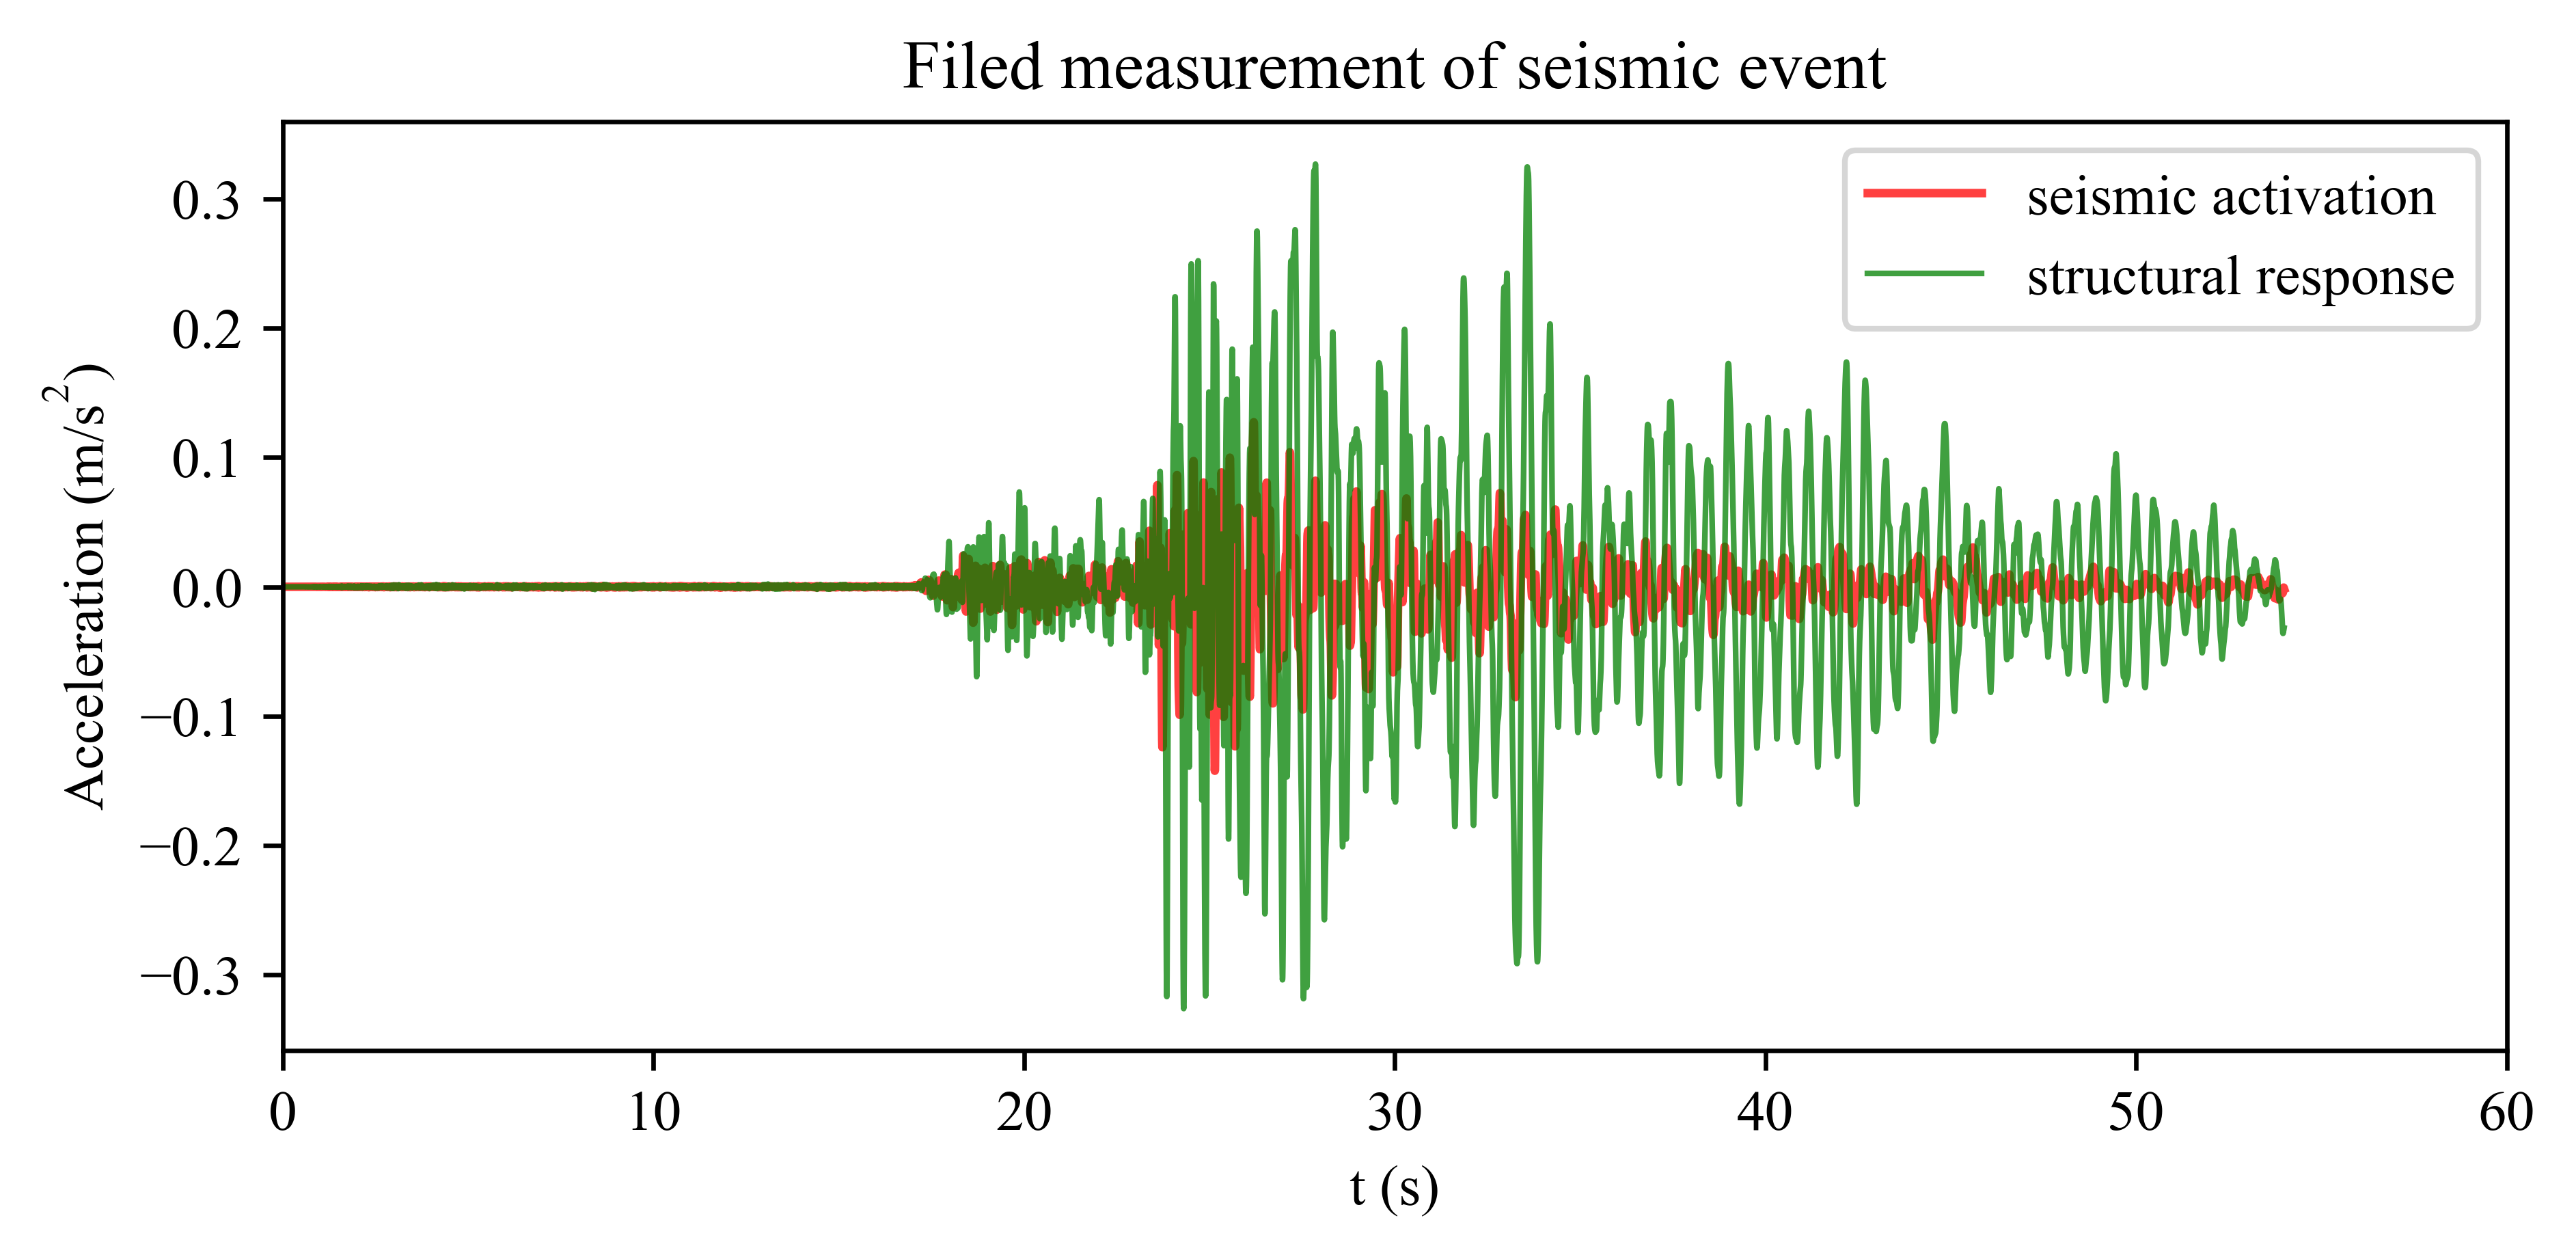

In [5]:
t1=np.arange(0,54,0.005)
t1.shape
idx_temp=5
sm1=ch01[0,:].T*0.01
sm2=ch06[0,:].T*0.01


fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t1,sm1,label='seismic activation',color='r',alpha=0.75)
plt.plot(t1,sm2,label='structural response',linestyle= '-',linewidth=1,color='g',alpha=0.75)
plt.xlim([0,60])
plt.xlabel('t (s)',fontsize=10,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=10,weight='normal')
plt.title('Filed measurement of seismic event')
plt.legend()
plt.show()

Hereby, we have obtained 15 samples of pairs between input seismic and output response, with dt=0.005s, sf=200Hz, points=10800, time duration=54s,*******
unit: cm/sec/sec

# 2 Model training and test

In [6]:
print(ch01.shape)
print(ch06.shape)

(15, 10800)
(15, 10800)


前10组数据用来训练（包括训练集和验证集），后5组数据用来测试, 剔除 0 10

In [7]:
# resampling the data, keep the time duration unchanged, but to change the sampling frequency for dara augmentation

def resample_data(raw_data,sample_ratio=10):
    n_sample=len(raw_data)
    raw_length=len(raw_data.T)
    new_length=int(raw_length/sample_ratio)
    new_data=np.zeros(new_length*n_sample*sample_ratio).reshape(n_sample*sample_ratio,new_length)
    for i in range(sample_ratio):
        new_data[i*n_sample:(i+1)*n_sample,:]=raw_data[:,i::sample_ratio]
    return new_data

In [70]:
X_exp_temp=ch01[[1,2,5,6,7,8,9,11,12,13,14],:]
y_exp_temp=ch06[[1,2,5,6,7,8,9,11,12,13,14],:]
# y_exp_temp=np.append(ch06[6:10,4000:6000],ch06[11:15,4000:6000],axis=0).reshape(-1,2000)

X_exp =resample_data(X_exp_temp,10)*0.01       #*0.01把单位从cm/sed/sed 转为 m/sec/sec
y_exp=resample_data(y_exp_temp,10)*0.01

X_exp_test=resample_data(ch01[[3,4],:],10)*0.01   #*0.01把单位从cm/sed/sed 转为 m/sec/sec
y_exp_test=resample_data(ch06[[3,4],:],10)*0.01

print('X_exp shape:',X_exp.shape)
print('X_exp_test shape:',X_exp_test.shape)

X_exp shape: (110, 1080)
X_exp_test shape: (20, 1080)


In [ ]:
# x_n1=wgn(X_exp,40)
# x_n2=wgn(X_exp,60)
# # x_n3=wgn(X_exp,80)
# # x_n4=wgn(X_exp,100)

# X_exp=np.append(x_n1,x_n2,axis=0)
# # X_exp_2=np.append(x_n3,x_n4,axis=0)
# # X_exp=np.append(X_exp_1,X_exp_2,axis=0)

# print(X_exp.shape)

In [ ]:
# y_n1=wgn(y_exp,40)
# y_n2=wgn(y_exp,60)
# # y_n3=wgn(y_exp,80)
# # y_n4=wgn(y_exp,100)

# y_exp=np.append(y_n1,y_n2,axis=0)
# # y_exp_2=np.append(y_n3,y_n4,axis=0)
# # y_exp=np.append(y_exp_1,y_exp_2,axis=0)

# print(y_exp.shape)

In [12]:
# X_exp =ch01[0:13,::10]*0.01    #*0.01把单位从cm/sed/sed 转为 m/sec/sec
# y_exp =ch06[0:13,::10]*0.01
# X_exp_test =ch01[13:15,::10]*0.01
# y_exp_test =ch06[13:15,::10]*0.01
# print('X_exp shape:',X_exp.shape)
# print('X_exp_test shape:',y_exp_test.shape)

In [13]:
# X_exp_test=resample_data(ch01[14:15,:],10)*0.01    #*0.01把单位从cm/sed/sed 转为 m/sec/sec
# y_exp_test=resample_data(ch06[14:15,:],10)*0.01
# print('X_exp_t shape:',X_exp_test.shape)
# print('y_exp_t shape:',y_exp_test.shape)

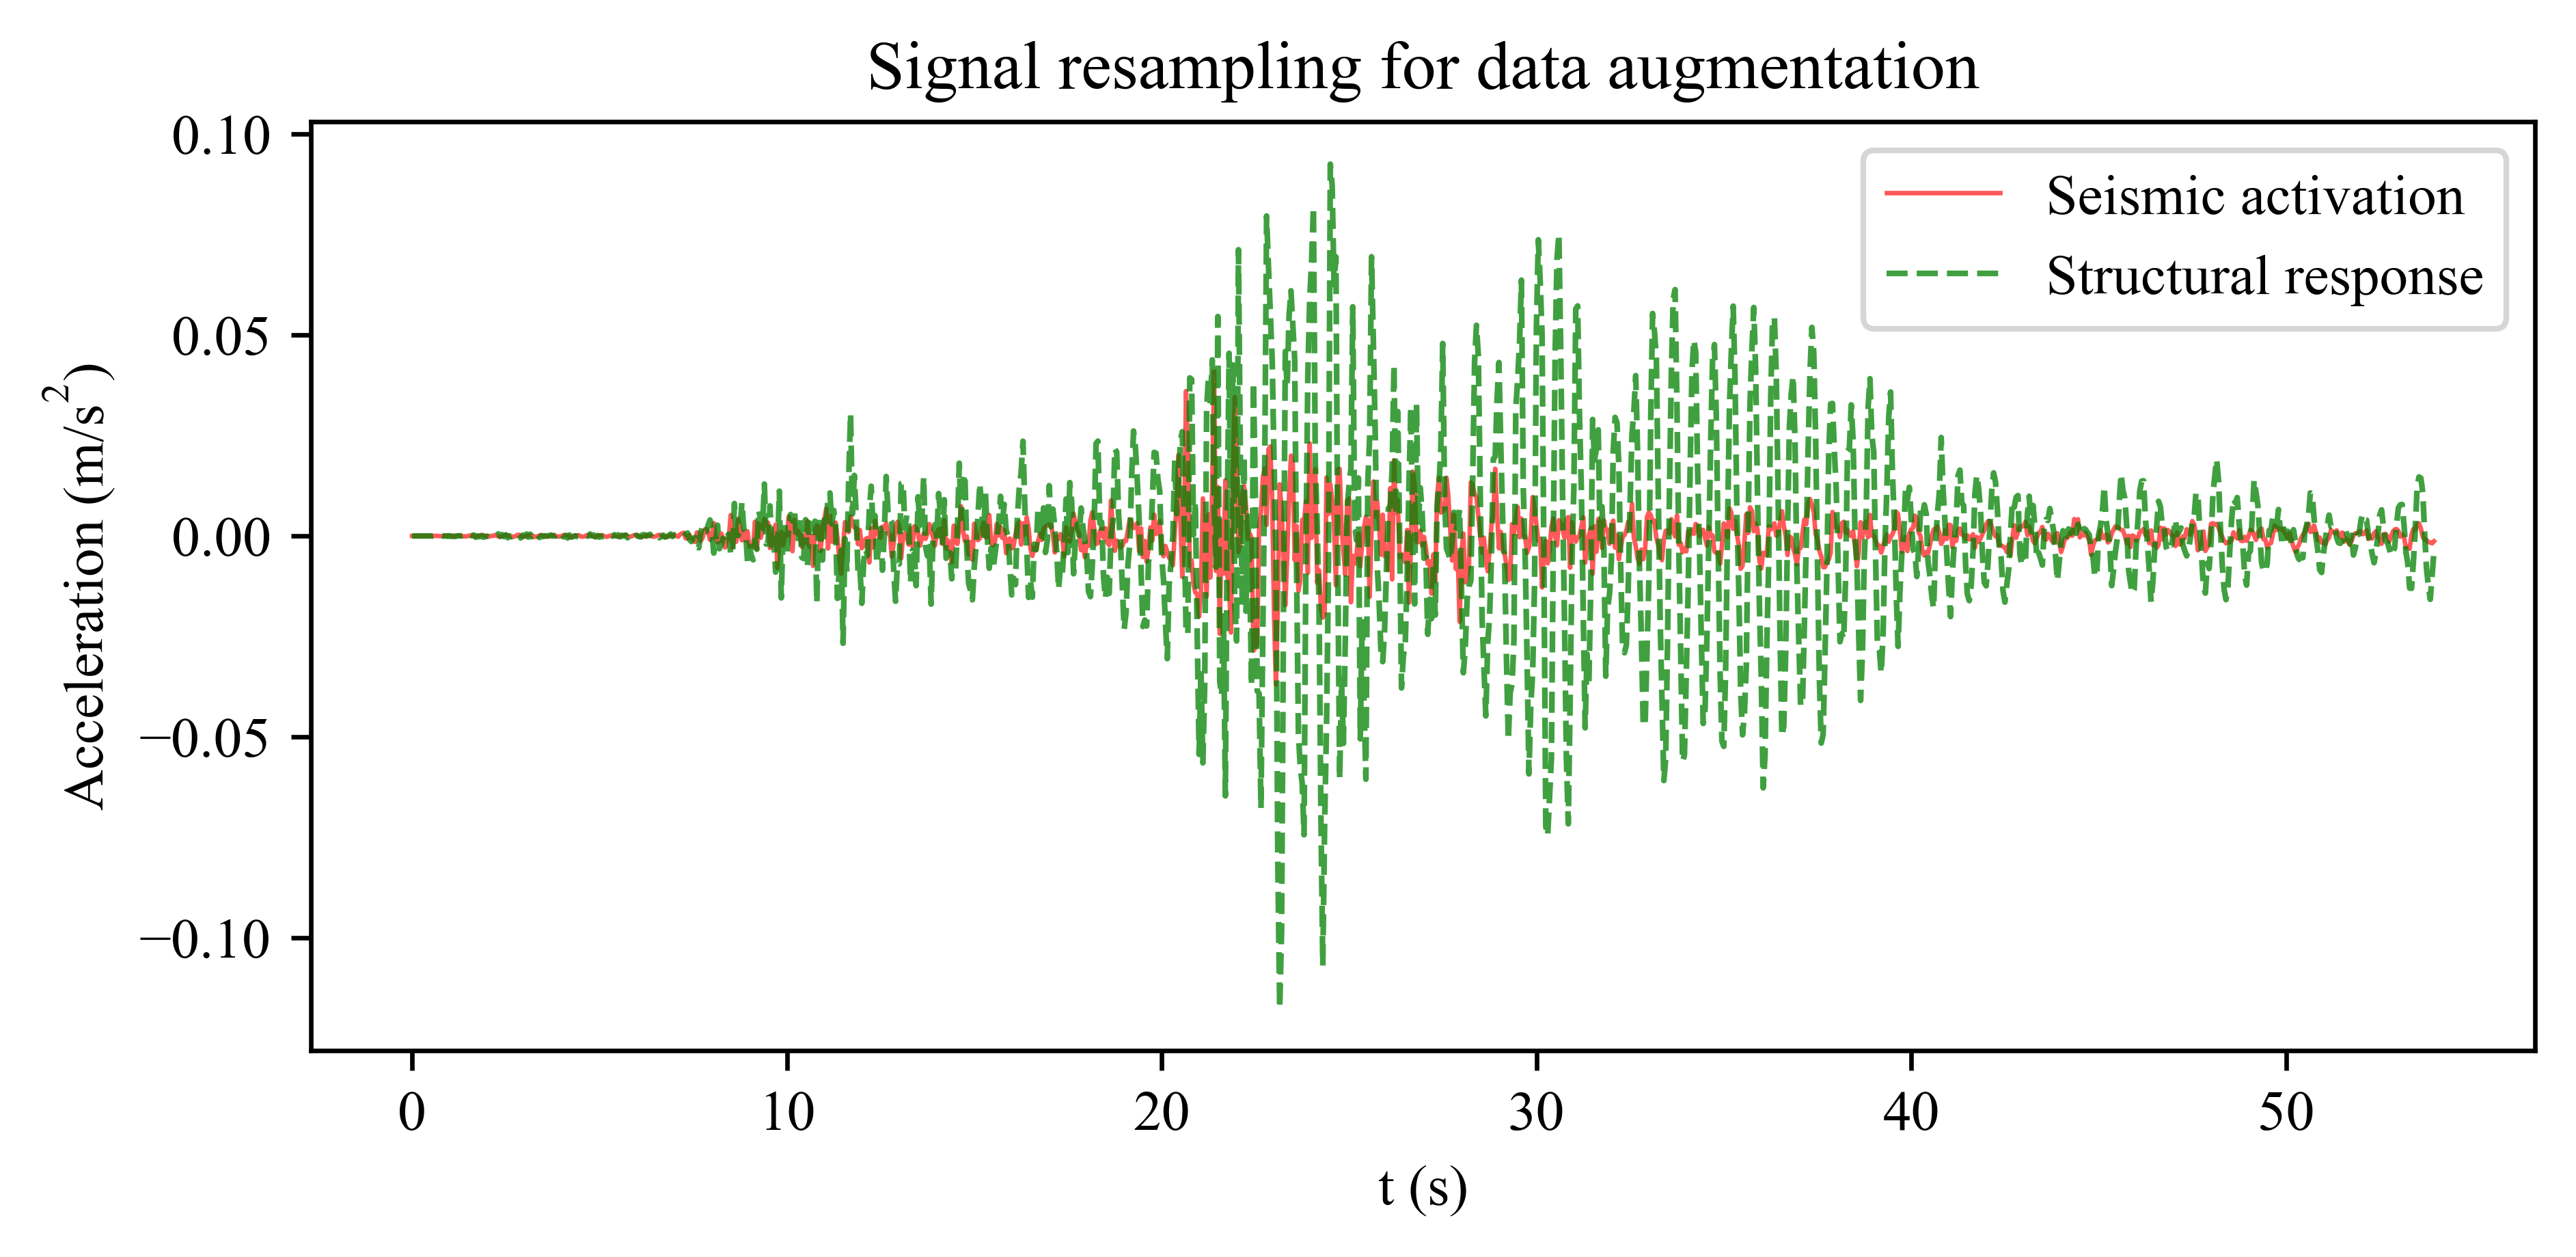

In [71]:
t1=np.arange(0,54,0.005*10)
t1.shape
idx_temp=0
sx1=X_exp_test [idx_temp,:].T
sx2=y_exp_test [idx_temp,:].T

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t1,sx1,label='Seismic activation',linewidth=0.8,color='r',alpha=0.65)
plt.plot(t1,sx2,label='Structural response',linestyle= '--',linewidth=1,color='g',alpha=0.75)
# plt.xlim([0,60])
plt.xlabel('t (s)',fontsize=10,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=10,weight='normal')
plt.title('Signal resampling for data augmentation')
plt.legend()
plt.show()

### CNN model define and training

In [127]:
# define the CNN model :model 3
input_shape=1080
model_input3=Input(shape=(input_shape,1))

conv1=Conv1D(filters=16,kernel_size=4,activation='tanh')(model_input3)
drop1=Dropout(0.5)(conv1)
pool1=MaxPooling1D(pool_size=2)(drop1)

conv2=Conv1D(filters=32,kernel_size=8,activation='tanh')(pool1)
drop2=Dropout(0.5)(conv2)
pool2=MaxPooling1D(pool_size=4)(drop2)

# # conv3=Conv1D(filters=64,kernel_size=16,activation='tanh')(pool2)
# drop3=Dropout(0.5)(conv3)
# pool3=MaxPooling1D(pool_size=2)(drop3)

flat=Flatten()(pool2)

dense1=Dense(512,activation='tanh')(flat)
BatchNormalization()
# dense2=Dense(256,activation='linear')(dense1)
BatchNormalization()
# dense3=Dense(512,activation='linear')(dense2)

model_output3=Dense(1080,activation='linear')(dense1)

model3=Model(model_input3,model_output3)

In [ ]:
# model3.summary()

In [128]:
from sklearn.model_selection import train_test_split

X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(X_exp, y_exp, test_size=0.20, random_state=0)

print(X_exp_train.shape)
print(X_exp_val.shape)

(88, 1080)
(22, 1080)


In [129]:
import time
time_start = time.process_time()

opt = keras.optimizers.Adam(lr=0.001)
callback =keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, baseline=None,restore_best_weights=False)
model3.compile(optimizer=opt, loss='mse')

history_auto3=model3.fit(X_exp_train, y_exp_train,
                epochs=500,
                batch_size=20,
                shuffle=True,
                validation_data=(X_exp_val, y_exp_val),
                callbacks=[callback]);

time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

Epoch 1/500
5/5 [==============================] - 2s 459ms/step - loss: 9.8986e-04 - val_loss: 5.8258e-04
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 8.9672e-04 - val_loss: 5.6264e-04
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 7.9368e-04 - val_loss: 5.4929e-04
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 7.5988e-04 - val_loss: 5.3608e-04
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 7.8960e-04 - val_loss: 5.2433e-04
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 7.8109e-04 - val_loss: 5.0703e-04
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 6.3060e-04 - val_loss: 4.9800e-04
Epoch 8/500
5/5 [==============================] - 0s 11ms/step - loss: 5.6849e-04 - val_loss: 4.8582e-04
Epoch 9/500
5/5 [==============================] - 0s 11ms/step - loss: 4.7591e-04 - val_loss: 4.4338e-04
Epoch 10/500
5/5 [===========================

5/5 [==============================] - 0s 13ms/step - loss: 5.0967e-05 - val_loss: 8.0469e-05
Epoch 154/500
5/5 [==============================] - 0s 21ms/step - loss: 5.5102e-05 - val_loss: 8.3140e-05
Epoch 155/500
5/5 [==============================] - 0s 17ms/step - loss: 5.3241e-05 - val_loss: 8.3778e-05
Epoch 156/500
5/5 [==============================] - 0s 13ms/step - loss: 5.7247e-05 - val_loss: 7.3917e-05
Epoch 157/500
5/5 [==============================] - 0s 13ms/step - loss: 5.4649e-05 - val_loss: 7.6324e-05
Epoch 158/500
5/5 [==============================] - 0s 13ms/step - loss: 5.6792e-05 - val_loss: 7.6615e-05
Epoch 159/500
5/5 [==============================] - 0s 13ms/step - loss: 5.4522e-05 - val_loss: 7.0278e-05
Epoch 160/500
5/5 [==============================] - 0s 12ms/step - loss: 5.3540e-05 - val_loss: 7.4850e-05
Epoch 161/500
5/5 [==============================] - 0s 14ms/step - loss: 5.0192e-05 - val_loss: 7.6455e-05
Epoch 162/500
5/5 [=======================

Epoch 304/500
5/5 [==============================] - 0s 12ms/step - loss: 3.7857e-05 - val_loss: 6.7024e-05
Epoch 305/500
5/5 [==============================] - 0s 13ms/step - loss: 3.6090e-05 - val_loss: 4.9499e-05
Epoch 306/500
5/5 [==============================] - 0s 12ms/step - loss: 3.0905e-05 - val_loss: 4.6536e-05
Epoch 307/500
5/5 [==============================] - 0s 19ms/step - loss: 3.7125e-05 - val_loss: 5.1715e-05
Epoch 308/500
5/5 [==============================] - 0s 22ms/step - loss: 3.4995e-05 - val_loss: 5.2938e-05
Epoch 309/500
5/5 [==============================] - 0s 74ms/step - loss: 3.3990e-05 - val_loss: 4.8909e-05
Epoch 310/500
5/5 [==============================] - 0s 12ms/step - loss: 3.8059e-05 - val_loss: 5.6675e-05
Epoch 311/500
5/5 [==============================] - 0s 12ms/step - loss: 3.7260e-05 - val_loss: 6.1385e-05
Epoch 312/500
5/5 [==============================] - 0s 11ms/step - loss: 3.5195e-05 - val_loss: 6.2365e-05
Epoch 313/500
5/5 [=========

Epoch 380/500
5/5 [==============================] - 0s 11ms/step - loss: 3.0792e-05 - val_loss: 5.3689e-05
Epoch 381/500
5/5 [==============================] - 0s 11ms/step - loss: 3.3861e-05 - val_loss: 5.3102e-05
Epoch 382/500
5/5 [==============================] - 0s 11ms/step - loss: 2.9788e-05 - val_loss: 5.3082e-05
Epoch 383/500
5/5 [==============================] - 0s 11ms/step - loss: 3.2495e-05 - val_loss: 4.9152e-05
Epoch 384/500
5/5 [==============================] - 0s 11ms/step - loss: 3.4728e-05 - val_loss: 5.5735e-05
Epoch 385/500
5/5 [==============================] - 0s 11ms/step - loss: 3.1508e-05 - val_loss: 5.2483e-05
Epoch 386/500
5/5 [==============================] - 0s 11ms/step - loss: 3.1357e-05 - val_loss: 5.1349e-05
Epoch 387/500
5/5 [==============================] - 0s 11ms/step - loss: 3.3330e-05 - val_loss: 5.9530e-05
Epoch 388/500
5/5 [==============================] - 0s 11ms/step - loss: 3.2634e-05 - val_loss: 5.9917e-05
Epoch 389/500
5/5 [=========

Epoch 456/500
5/5 [==============================] - 0s 12ms/step - loss: 2.9153e-05 - val_loss: 4.6044e-05
Epoch 457/500
5/5 [==============================] - 0s 12ms/step - loss: 2.6132e-05 - val_loss: 5.0924e-05
Epoch 458/500
5/5 [==============================] - 0s 13ms/step - loss: 2.8471e-05 - val_loss: 5.6499e-05
Epoch 459/500
5/5 [==============================] - 0s 13ms/step - loss: 3.2777e-05 - val_loss: 5.4683e-05
Epoch 460/500
5/5 [==============================] - 0s 12ms/step - loss: 3.3018e-05 - val_loss: 4.9468e-05
Epoch 461/500
5/5 [==============================] - 0s 13ms/step - loss: 3.0871e-05 - val_loss: 5.4911e-05
Epoch 462/500
5/5 [==============================] - 0s 13ms/step - loss: 3.1422e-05 - val_loss: 5.3130e-05
Epoch 463/500
5/5 [==============================] - 0s 12ms/step - loss: 2.9559e-05 - val_loss: 5.3845e-05
Epoch 464/500
5/5 [==============================] - 0s 13ms/step - loss: 2.9741e-05 - val_loss: 5.6924e-05
Epoch 465/500
5/5 [=========

D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


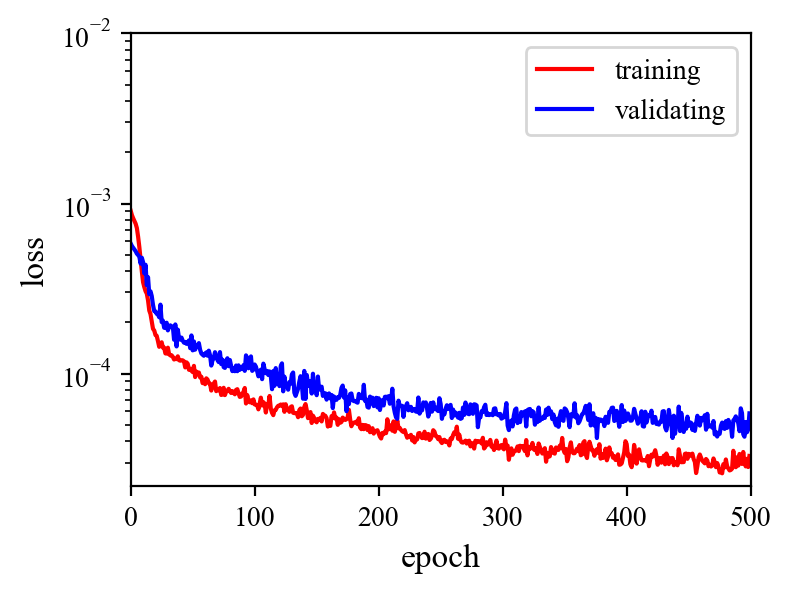

In [193]:
fig = plt.figure(figsize=(4, 3), dpi=200)
plt.rc('font',family='Times New Roman')
plt.axes(yscale='log')
plt.plot(history_auto3.history['loss'],'r',label='training')
plt.plot(history_auto3.history['val_loss'],'b',label='validating')
plt.xlabel('epoch',fontsize=12,weight='normal')
plt.ylabel('loss',fontsize=12,weight='normal')
plt.xlim([0,500])
plt.ylim([0,0.01])
plt.legend()
plt.show()

In [109]:
# history_auto3.history['loss']

In [205]:
sr_exp_train=model3.predict(X_exp_train[:,:])
sr_exp_val=model3.predict(X_exp_val[:,:])
sr_exp_test=model3.predict(X_exp_test[:,:])

In [206]:
ci_exp_train=get_CI(sr_exp_train,y_exp_train)
ci_exp_val=get_CI(sr_exp_val,y_exp_val)
ci_exp_test=get_CI(sr_exp_test,y_exp_test)

In [207]:
ci_exp_train.shape

(88,)

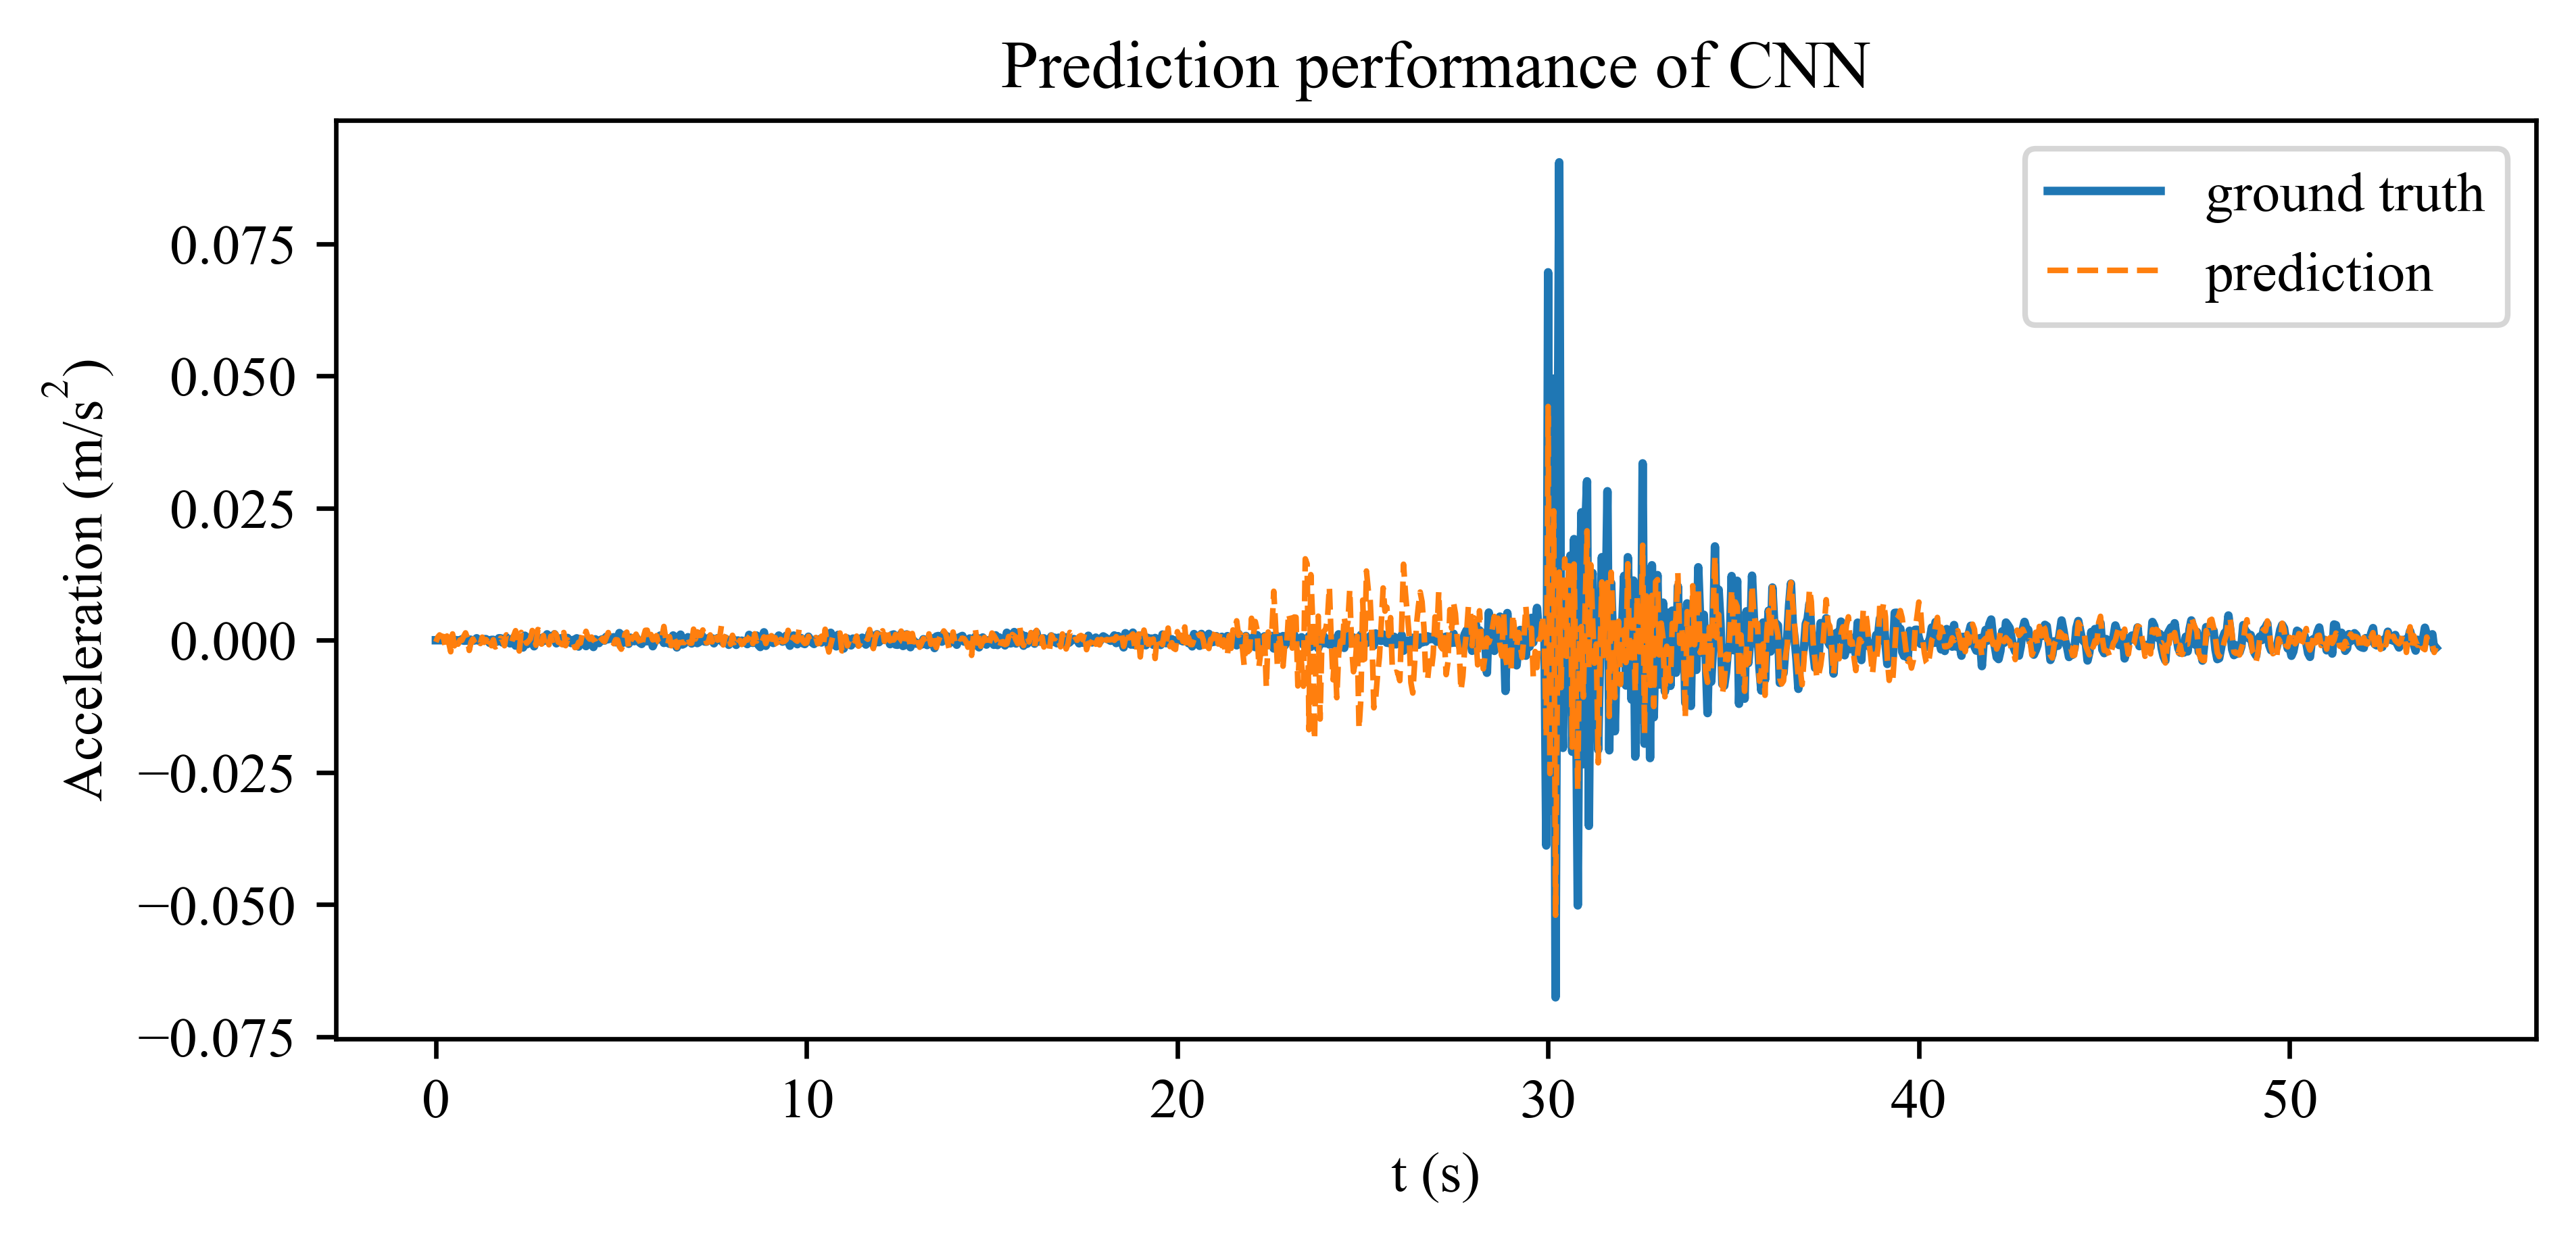

In [52]:
k_temp=np.argmax(ci_exp_test)       # random select a raw of signal
L=len(X_exp.T)
r_exp_pre=sr_exp_val[k_temp,:].reshape(L,1)
r_exp_real=y_exp_val[k_temp,:].reshape(L,1)

# r_exp_pre=sr_exp_test[k_temp,:].reshape(L,1)
# r_exp_real=y_exp_test[k_temp,:].reshape(L,1)

t0=np.arange(0,54,0.005*10)
t0.shape

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t0,r_exp_real,label='ground truth')
plt.plot(t0,r_exp_pre,label='prediction',linestyle= '--',linewidth=1)
plt.xlabel('t (s)',fontsize=10,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=10,weight='normal')
plt.title('Prediction performance of CNN')
# plt.title('Prediction performance : velocity (m/s)')
# plt.title('Prediction performance : acceleration (m/$\mathregular{s^2}$)')
plt.legend()
# plt.grid()
plt.show()

In [53]:
import scipy

def get_CI(x, y):
    ci=np.zeros(len(x))
    for i in range(len(x)):
        ci[i]=scipy.stats.linregress(x[i,:], y[i,:]).rvalue
    return ci


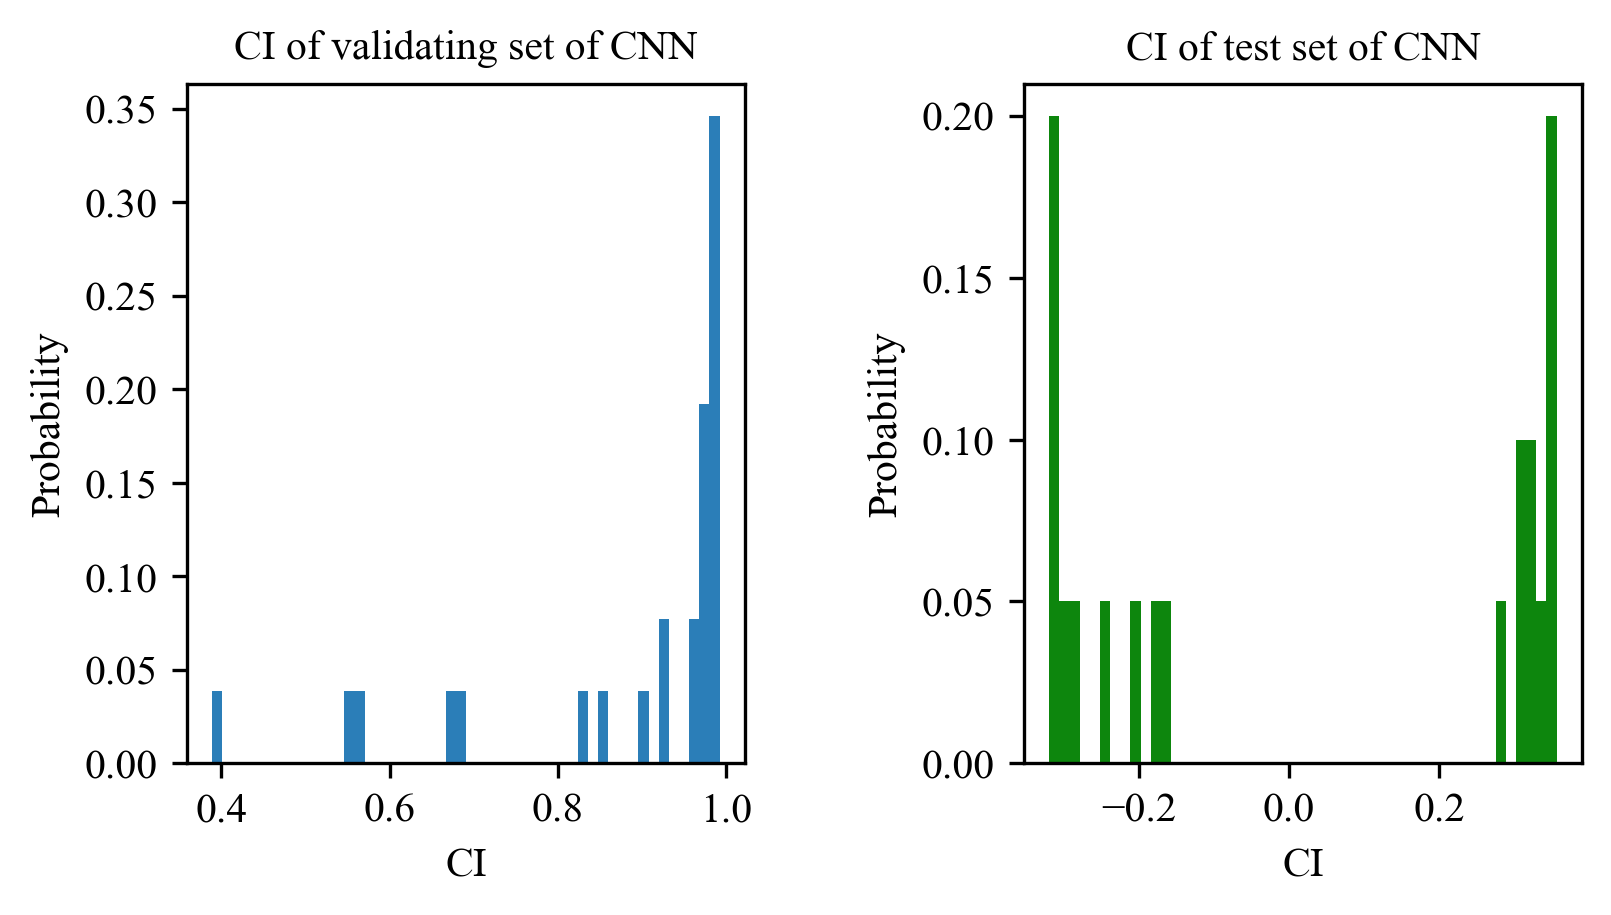

In [54]:
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_exp_val=np.ones_like(ci_exp_val)/float(len(ci_exp_val))
ax1.hist(ci_exp_val,50,weights=weights_exp_val,histtype='stepfilled',alpha=0.95)
ax1.set_title('CI of validating set of CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')

weights_exp_test=np.ones_like(ci_exp_test)/float(len(ci_exp_test))
ax2.hist(ci_exp_test,50,weights=weights_exp_test,histtype='stepfilled',color='g',alpha=0.95)
ax2.set_title('CI of test set of CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')

f.subplots_adjust(wspace =0.5, hspace =2)

In [55]:
# calaulate the quartiles of CI 
qua_exp_train = np.percentile(ci_exp_val, (25, 50, 75), interpolation='midpoint')
qua_exp_test= np.percentile(ci_exp_test, (25, 50, 75), interpolation='midpoint')
print('The CI quartiles of validating set', qua_exp_train)
print('The CI quartiles of testing set', qua_exp_test)

The CI quartiles of validating set [0.88084681 0.97177362 0.98558528]
The CI quartiles of testing set [-0.29521901  0.06339609  0.33149491]


### SSM-CNN model define and training 

In [122]:
input_shape=1080
model_input4=Input(shape=(input_shape,1))
conv21=Conv1D(filters=16,kernel_size=4,activation='tanh')(model_input4)

drop21=Dropout(0.5)(conv21)
pool21=MaxPooling1D(pool_size=2)(drop21)

conv22=Conv1D(filters=32,kernel_size=8,activation='tanh')(pool21)
drop22=Dropout(0.5)(conv22)
pool22=MaxPooling1D(pool_size=2)(drop22)


# conv23=Conv1D(filters=64,kernel_size=16,activation='tanh')(pool22)
# drop23=Dropout(0.5)(conv23)
# pool23=MaxPooling1D(pool_size=2)(drop23)

flat2=Flatten()(pool22)

dense21=Dense(1512,activation='tanh')(flat2)
BatchNormalization()
# dense22=Dense(256,activation='linear')(dense21)
# dense23=Dense(512,activation='linear')(dense22)
model_output4=Dense(1080,activation='linear')(dense21)

model4=Model(model_input4,model_output4)

In [123]:
import time

time_start = time.process_time()
opt = keras.optimizers.Adam(lr=0.001)
callback =keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, baseline=None,restore_best_weights=False)

model4.compile(loss=custom_loss, optimizer=opt)

history_auto4=model4.fit(X_exp_train, y_exp_train,
                epochs=500,
                batch_size=20,
                shuffle=True,
                validation_data=(X_exp_val, y_exp_val),
                callbacks=[callback]);

time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

Epoch 1/500
6/6 [==============================] - 1s 83ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 2/500
6/6 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/500
6/6 [==============================] - 0s 17ms/step - loss: 9.9309e-04 - val_loss: 0.0012
Epoch 4/500
6/6 [==============================] - 0s 14ms/step - loss: 8.6268e-04 - val_loss: 0.0012
Epoch 5/500
6/6 [==============================] - 0s 13ms/step - loss: 7.3571e-04 - val_loss: 9.0065e-04
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 6.0641e-04 - val_loss: 7.8266e-04
Epoch 7/500
6/6 [==============================] - 0s 14ms/step - loss: 5.0071e-04 - val_loss: 6.2693e-04
Epoch 8/500
6/6 [==============================] - 0s 14ms/step - loss: 5.1805e-04 - val_loss: 6.5614e-04
Epoch 9/500
6/6 [==============================] - 0s 13ms/step - loss: 4.2334e-04 - val_loss: 5.1122e-04
Epoch 10/500
6/6 [==============================] - 0s 14ms/step - los

Epoch 78/500
6/6 [==============================] - 0s 16ms/step - loss: 1.0325e-04 - val_loss: 1.3450e-04
Epoch 79/500
6/6 [==============================] - 0s 13ms/step - loss: 1.0208e-04 - val_loss: 1.0998e-04
Epoch 80/500
6/6 [==============================] - 0s 13ms/step - loss: 1.1416e-04 - val_loss: 1.0498e-04
Epoch 81/500
6/6 [==============================] - 0s 13ms/step - loss: 1.0510e-04 - val_loss: 9.9486e-05
Epoch 82/500
6/6 [==============================] - 0s 13ms/step - loss: 1.0719e-04 - val_loss: 1.1532e-04
Epoch 83/500
6/6 [==============================] - 0s 13ms/step - loss: 1.1370e-04 - val_loss: 1.2899e-04
Epoch 84/500
6/6 [==============================] - 0s 13ms/step - loss: 1.0944e-04 - val_loss: 1.0217e-04
Epoch 85/500
6/6 [==============================] - 0s 13ms/step - loss: 9.3103e-05 - val_loss: 9.9193e-05
Epoch 86/500
6/6 [==============================] - 0s 13ms/step - loss: 9.4450e-05 - val_loss: 1.1915e-04
Epoch 87/500
6/6 [===================

6/6 [==============================] - 0s 14ms/step - loss: 9.0322e-05 - val_loss: 7.7669e-05
Epoch 155/500
6/6 [==============================] - 0s 13ms/step - loss: 8.4673e-05 - val_loss: 7.9770e-05
Epoch 156/500
6/6 [==============================] - 0s 13ms/step - loss: 7.6412e-05 - val_loss: 7.1794e-05
Epoch 157/500
6/6 [==============================] - 0s 13ms/step - loss: 7.6196e-05 - val_loss: 7.3233e-05
Epoch 158/500
6/6 [==============================] - 0s 13ms/step - loss: 7.6475e-05 - val_loss: 8.4750e-05
Epoch 159/500
6/6 [==============================] - 0s 13ms/step - loss: 8.4600e-05 - val_loss: 8.1032e-05
Epoch 160/500
6/6 [==============================] - 0s 13ms/step - loss: 6.9379e-05 - val_loss: 8.0857e-05
Epoch 161/500
6/6 [==============================] - 0s 13ms/step - loss: 8.2804e-05 - val_loss: 9.0190e-05
Epoch 162/500
6/6 [==============================] - 0s 13ms/step - loss: 9.5352e-05 - val_loss: 8.0553e-05
Epoch 163/500
6/6 [=======================

Epoch 230/500
6/6 [==============================] - 0s 13ms/step - loss: 5.3907e-05 - val_loss: 6.0661e-05
Epoch 231/500
6/6 [==============================] - 0s 14ms/step - loss: 5.7217e-05 - val_loss: 7.5022e-05
Epoch 232/500
6/6 [==============================] - 0s 14ms/step - loss: 6.0374e-05 - val_loss: 8.7137e-05
Epoch 233/500
6/6 [==============================] - 0s 16ms/step - loss: 7.5927e-05 - val_loss: 6.1313e-05
Epoch 234/500
6/6 [==============================] - 0s 14ms/step - loss: 6.3512e-05 - val_loss: 5.6822e-05
Epoch 235/500
6/6 [==============================] - 0s 17ms/step - loss: 5.9656e-05 - val_loss: 6.1390e-05
Epoch 236/500
6/6 [==============================] - 0s 14ms/step - loss: 6.6786e-05 - val_loss: 6.8495e-05
Epoch 237/500
6/6 [==============================] - 0s 14ms/step - loss: 6.9368e-05 - val_loss: 6.6304e-05
Epoch 238/500
6/6 [==============================] - 0s 14ms/step - loss: 7.8558e-05 - val_loss: 7.9899e-05
Epoch 239/500
6/6 [=========

Epoch 306/500
6/6 [==============================] - 0s 14ms/step - loss: 6.2207e-05 - val_loss: 6.5361e-05
Epoch 307/500
6/6 [==============================] - 0s 14ms/step - loss: 7.4515e-05 - val_loss: 7.2982e-05
Epoch 308/500
6/6 [==============================] - 0s 13ms/step - loss: 8.0097e-05 - val_loss: 6.2339e-05
Epoch 309/500
6/6 [==============================] - 0s 13ms/step - loss: 5.9338e-05 - val_loss: 6.2756e-05
Epoch 310/500
6/6 [==============================] - 0s 13ms/step - loss: 5.4546e-05 - val_loss: 6.4430e-05
Epoch 311/500
6/6 [==============================] - 0s 13ms/step - loss: 6.1191e-05 - val_loss: 7.1311e-05
Epoch 312/500
6/6 [==============================] - 0s 13ms/step - loss: 6.0216e-05 - val_loss: 7.2089e-05
Epoch 313/500
6/6 [==============================] - 0s 13ms/step - loss: 6.5119e-05 - val_loss: 7.0504e-05
Epoch 314/500
6/6 [==============================] - 0s 14ms/step - loss: 5.9033e-05 - val_loss: 5.6270e-05
Epoch 315/500
6/6 [=========

Epoch 382/500
6/6 [==============================] - 0s 14ms/step - loss: 5.4111e-05 - val_loss: 4.5424e-05
Epoch 383/500
6/6 [==============================] - 0s 14ms/step - loss: 5.9136e-05 - val_loss: 5.7539e-05
Epoch 384/500
6/6 [==============================] - 0s 14ms/step - loss: 6.5236e-05 - val_loss: 5.8314e-05
Epoch 385/500
6/6 [==============================] - 0s 22ms/step - loss: 5.6406e-05 - val_loss: 4.8656e-05
Epoch 386/500
6/6 [==============================] - 0s 13ms/step - loss: 5.2804e-05 - val_loss: 5.5355e-05
Epoch 387/500
6/6 [==============================] - 0s 13ms/step - loss: 6.9948e-05 - val_loss: 5.4817e-05
Epoch 388/500
6/6 [==============================] - 0s 13ms/step - loss: 6.0976e-05 - val_loss: 4.6529e-05
Epoch 389/500
6/6 [==============================] - 0s 14ms/step - loss: 4.6061e-05 - val_loss: 4.5799e-05
Epoch 390/500
6/6 [==============================] - 0s 13ms/step - loss: 4.9929e-05 - val_loss: 4.7478e-05
Epoch 391/500
6/6 [=========

Epoch 458/500
6/6 [==============================] - 0s 15ms/step - loss: 4.9001e-05 - val_loss: 4.4731e-05
Epoch 459/500
6/6 [==============================] - 0s 14ms/step - loss: 5.1197e-05 - val_loss: 5.4499e-05
Epoch 460/500
6/6 [==============================] - 0s 14ms/step - loss: 5.1596e-05 - val_loss: 4.6880e-05
Epoch 461/500
6/6 [==============================] - 0s 16ms/step - loss: 5.0014e-05 - val_loss: 4.4448e-05
Epoch 462/500
6/6 [==============================] - 0s 16ms/step - loss: 4.9672e-05 - val_loss: 5.2629e-05
Epoch 463/500
6/6 [==============================] - 0s 18ms/step - loss: 5.3684e-05 - val_loss: 4.4683e-05
Epoch 464/500
6/6 [==============================] - 0s 14ms/step - loss: 5.5024e-05 - val_loss: 4.6246e-05
Epoch 465/500
6/6 [==============================] - 0s 14ms/step - loss: 5.1181e-05 - val_loss: 6.0924e-05
Epoch 466/500
6/6 [==============================] - 0s 15ms/step - loss: 5.8678e-05 - val_loss: 4.3677e-05
Epoch 467/500
6/6 [=========

D:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


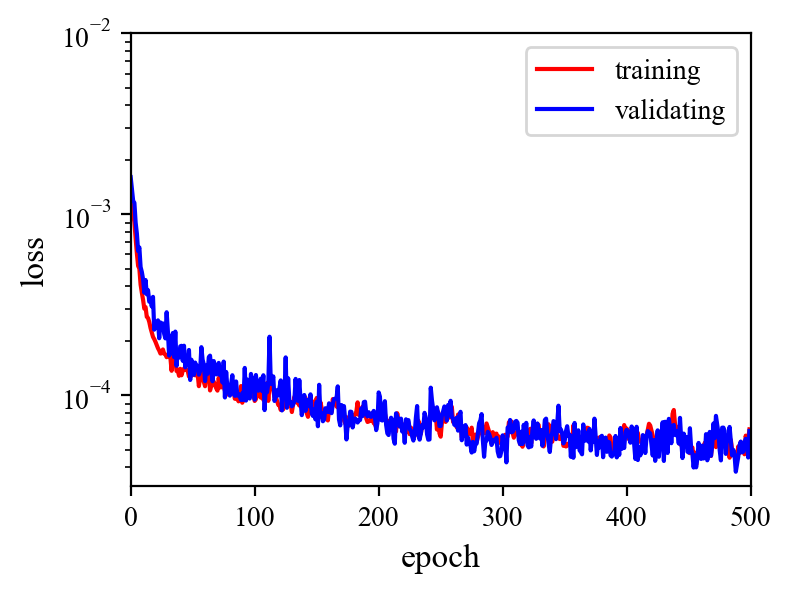

In [125]:
fig = plt.figure(figsize=(4, 3), dpi=200)
plt.rc('font',family='Times New Roman')
plt.axes(yscale='log')
plt.plot(history_auto4.history['loss'],'r',label='training')
plt.plot(history_auto4.history['val_loss'],'b',label='validating')

plt.xlabel('epoch',fontsize=12,weight='normal')
plt.ylabel('loss',fontsize=12,weight='normal')
plt.xlim([0,500])
plt.ylim([0,0.01])
plt.legend()
plt.show()

In [209]:
# allocate the trained model for prediction
sr_exp_ssm_train=model4.predict(X_exp_train)
sr_exp_ssm_val=model4.predict(X_exp_val)
sr_exp_ssm_test=model4.predict(X_exp_test)

In [210]:
ci_exp_ssm_train=get_CI(sr_exp_ssm_train,y_exp_train)
ci_exp_ssm_val=get_CI(sr_exp_ssm_val,y_exp_val)
ci_exp_ssm_test=get_CI(sr_exp_ssm_test,y_exp_test)

In [79]:
sr_exp_val.shape

(26, 1080)

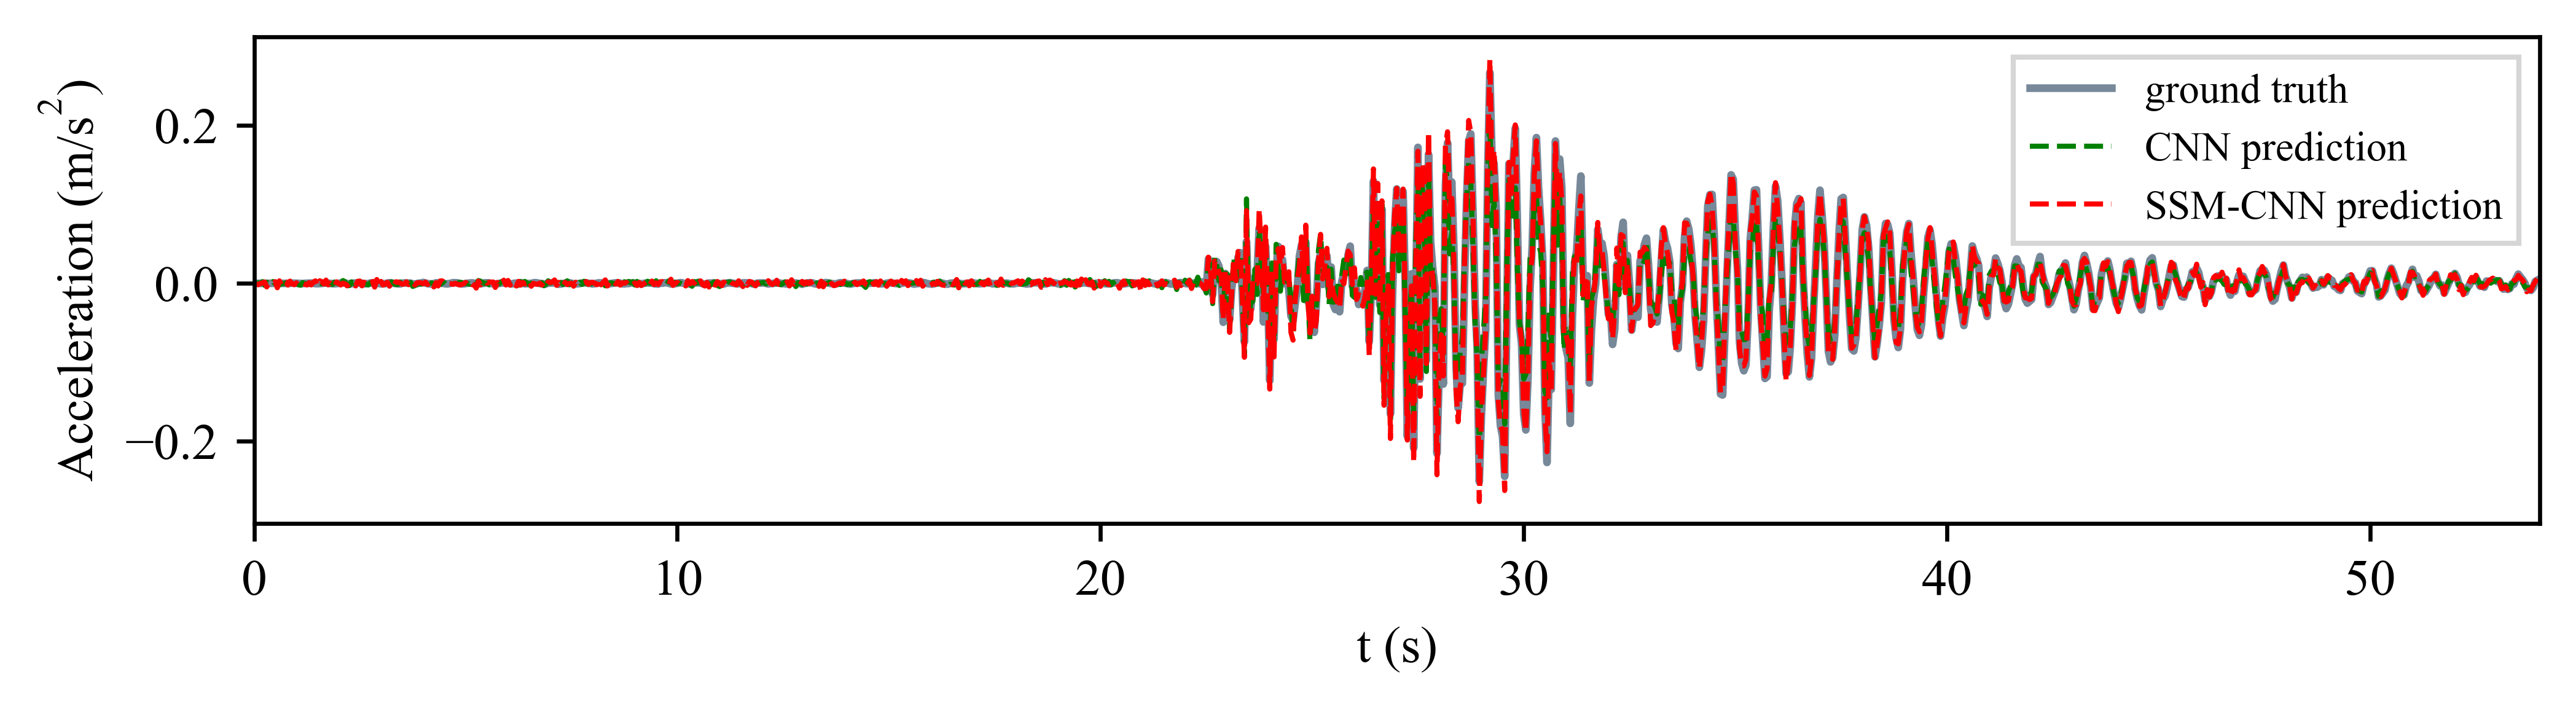

In [103]:
k_temp=4 # random select a raw of signal
L=len(X_exp.T)

r_pre=sr_exp_val[k_temp,:].reshape(L,1)
r_ssm_pre=sr_exp_ssm_val[k_temp,:].reshape(L,1)
r_real=y_exp_val[k_temp,:].reshape(L,1)

t0=np.arange(0,54,0.05)
t0.shape

fig = plt.figure(figsize=(8, 1.75), dpi=600)

plt.rc('font',family='Times New Roman')
plt.plot(t0,r_real,label='ground truth',color='#778899')
plt.plot(t0,r_pre,label='CNN prediction',linestyle= '--',linewidth=1,color='g')
plt.plot(t0,r_ssm_pre,label='SSM-CNN prediction',linestyle= '--',linewidth=1,color='r')
plt.xlim([0,54])
plt.xlabel('t (s)',fontsize=10,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=10,weight='normal')

plt.legend(loc='upper right',fontsize=8,facecolor='white',fancybox=False)
plt.show()

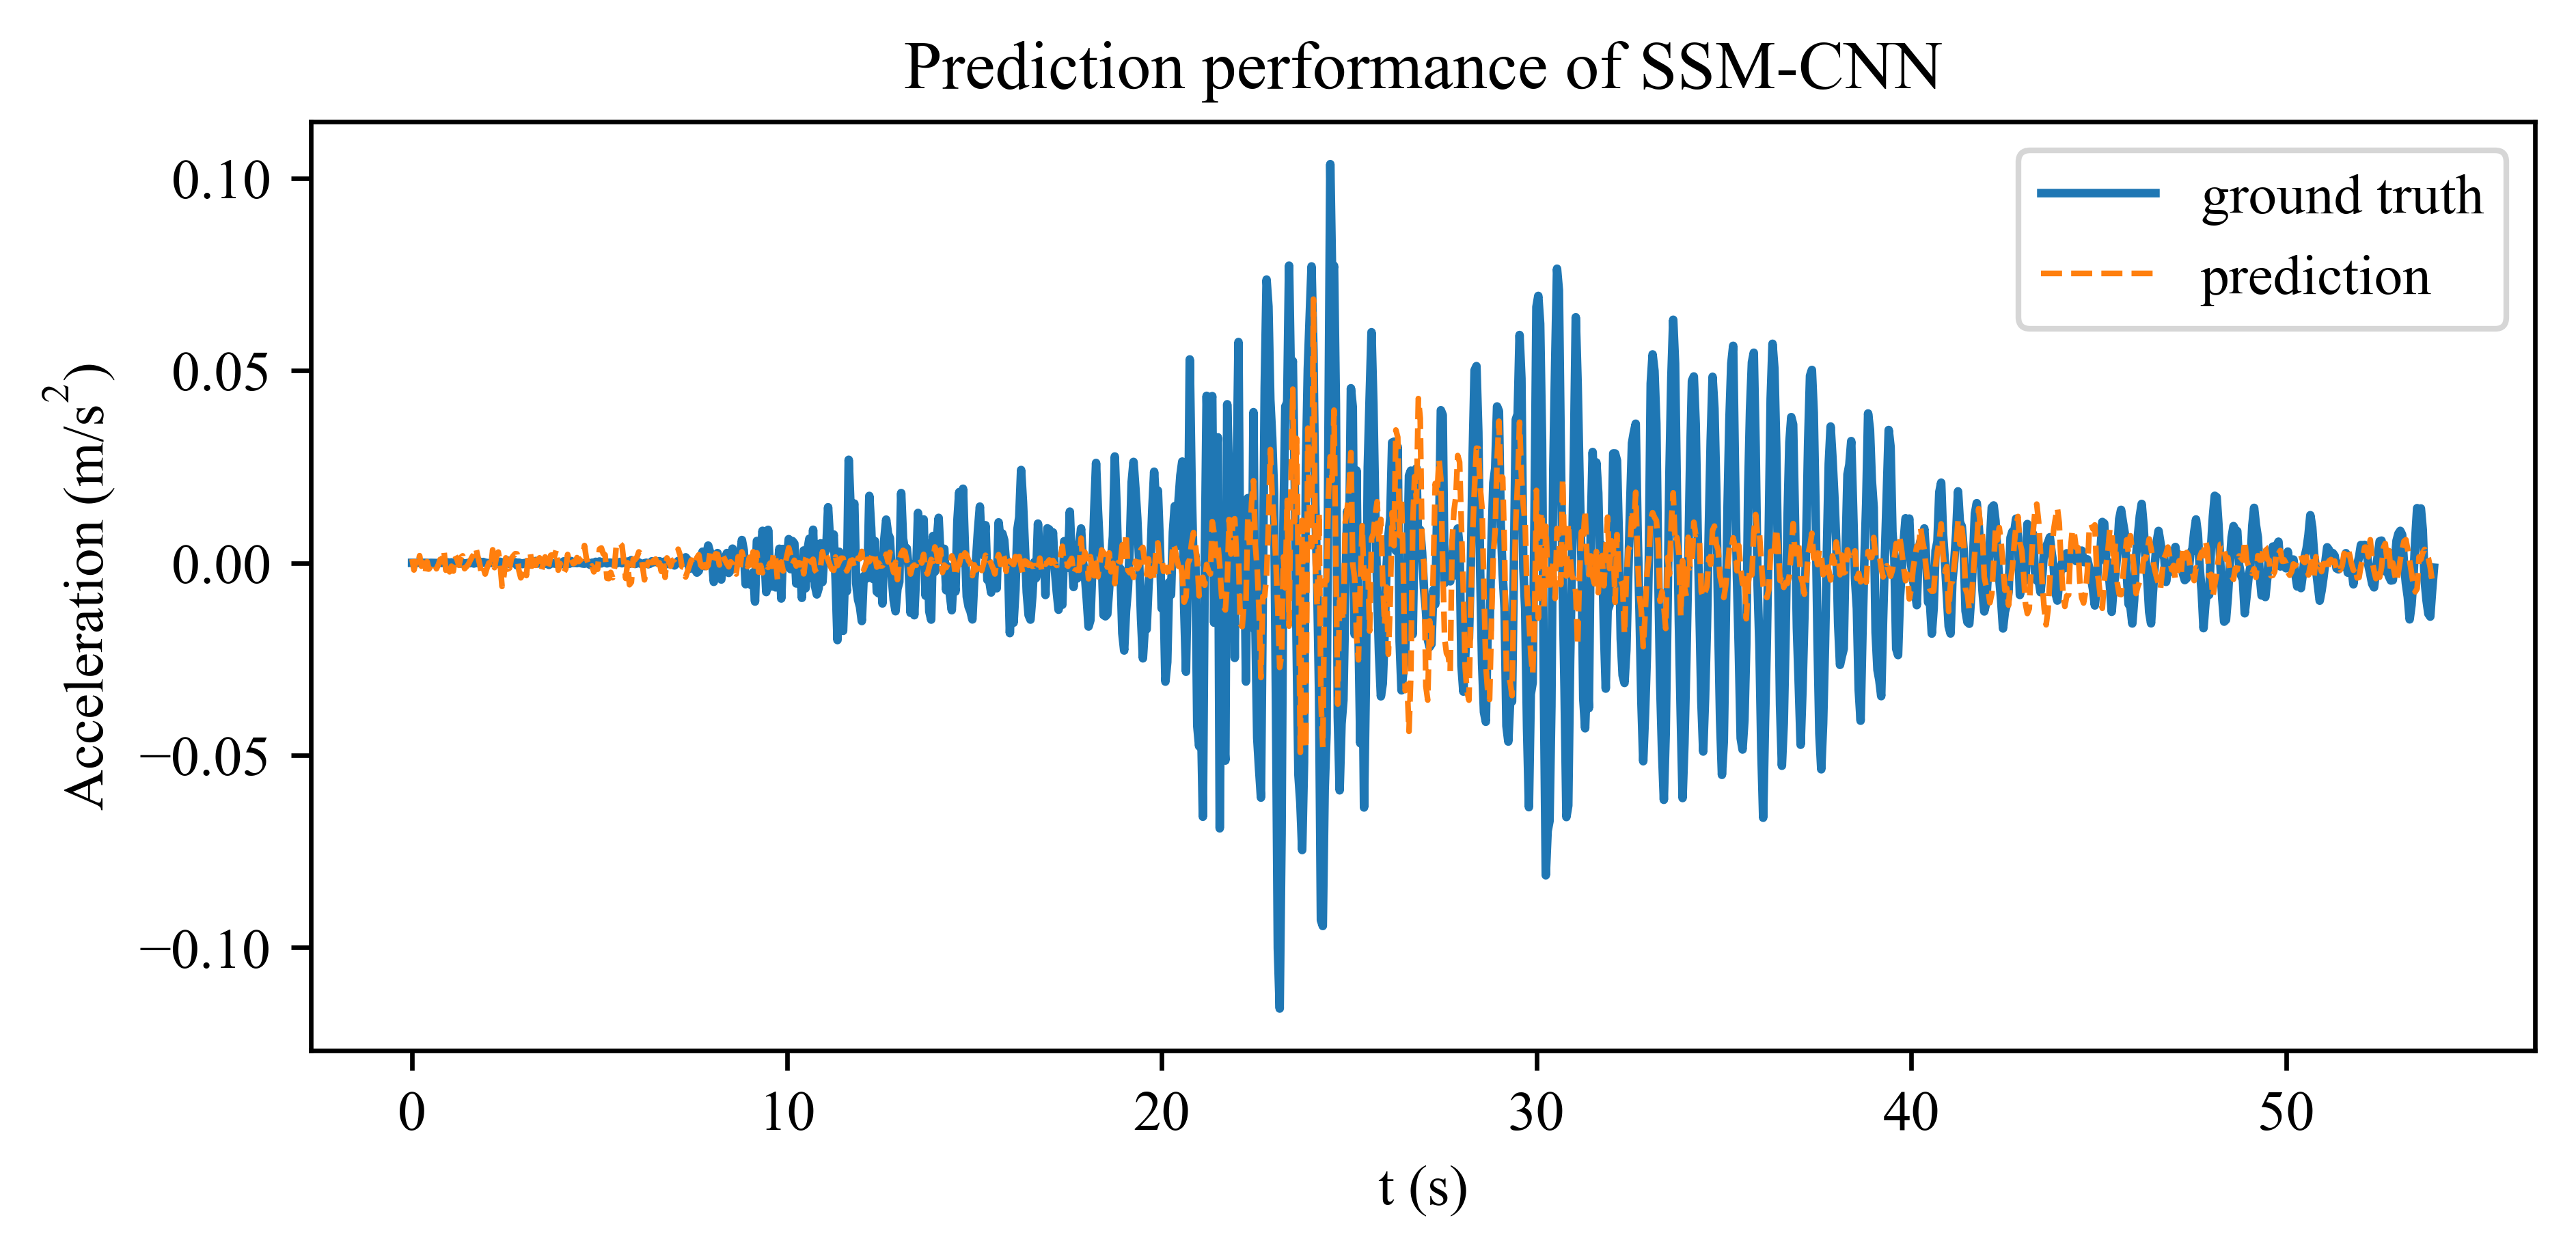

In [192]:
k_temp=np.argmax(ci_exp_test) # random select a raw of signal
L=len(X_exp.T)

# r_pre=sr_exp_ssm_val[k_temp,:].reshape(L,1)
# r_real=y_exp_val[k_temp,:].reshape(L,1)

r_pre=sr_exp_ssm_test[k_temp,:].reshape(L,1)
r_real=y_exp_test[k_temp,:].reshape(L,1)

t0=np.arange(0,54,0.005*10)
t0.shape

fig = plt.figure(figsize=(7, 3), dpi=600)
plt.rc('font',family='Times New Roman')
plt.plot(t0,r_real,label='ground truth')
plt.plot(t0,r_pre,label='prediction',linestyle= '--',linewidth=1)
plt.xlabel('t (s)',fontsize=10,weight='normal')
plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=10,weight='normal')
plt.title('Prediction performance of SSM-CNN')
# plt.title('Prediction performance : velocity (m/s)')
plt.legend()
plt.show()


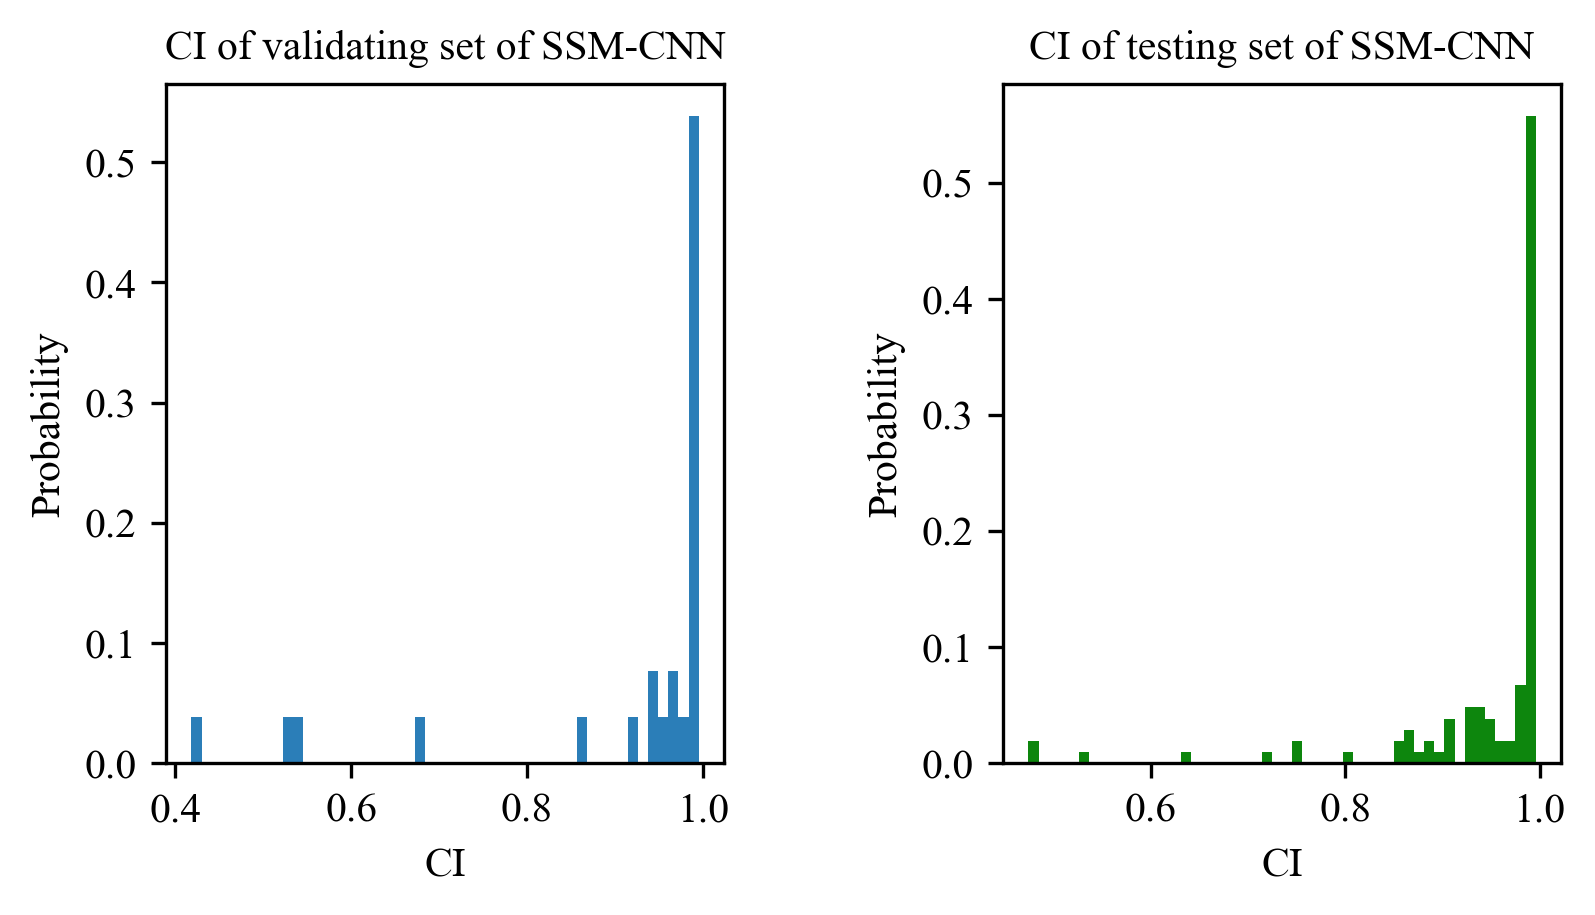

In [67]:
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_exp_ssm_val=np.ones_like(ci_exp_ssm_val)/float(len(ci_exp_ssm_val))
ax1.hist(ci_exp_ssm_val,50,weights=weights_exp_ssm_val,histtype='stepfilled',alpha=0.95)
ax1.set_title('CI of validating set of SSM-CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')

weights_exp_ssm_train=np.ones_like(ci_exp_ssm_train)/float(len(ci_exp_ssm_train))
ax2.hist(ci_exp_ssm_train,50,weights=weights_exp_ssm_train,histtype='stepfilled',color='g',alpha=0.95)
ax2.set_title('CI of testing set of SSM-CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')

f.subplots_adjust(wspace =0.5, hspace =2)

In [69]:
# calaulate the quartiles of CI 
qua_exp_train= np.percentile(ci_exp_train, (25, 50, 75), interpolation='midpoint')
qua_exp_val= np.percentile(ci_exp_val, (25, 50, 75), interpolation='midpoint')
qua_exp_test= np.percentile(ci_exp_test, (25, 50, 75), interpolation='midpoint')
print('The CI quartiles of validating set of CNN', qua_exp_val)
print('The CI quartiles of training set of CNN', qua_exp_train)

The CI quartiles of validating set of CNN [0.88084681 0.97177362 0.98558528]
The CI quartiles of training set of CNN [0.93098101 0.98106372 0.9884917 ]


In [63]:
np.max(ci_exp_test)

0.3566243843157354

In [75]:
# calaulate the quartiles of CI of SSM-CNN
qua_exp_ssm_train = np.percentile(ci_exp_ssm_train, (25, 50, 75), interpolation='midpoint')
qua_exp_ssm_val = np.percentile(ci_exp_ssm_val, (25, 50, 75), interpolation='midpoint')
qua_exp_ssm_test= np.percentile(ci_exp_ssm_test, (25, 50, 75), interpolation='midpoint')

print('The CI quartiles of validating set by SSM-CNN', qua_exp_ssm_val)
print('The CI quartiles of trainig set by SSM-CNN', qua_exp_ssm_train)

The CI quartiles of validating set by SSM-CNN [0.94052794 0.98573601 0.99069463]
The CI quartiles of trainig set by SSM-CNN [0.93182176 0.98816037 0.99190826]


In [42]:
np.max(ci_exp_ssm_test)

0.38529590299401917

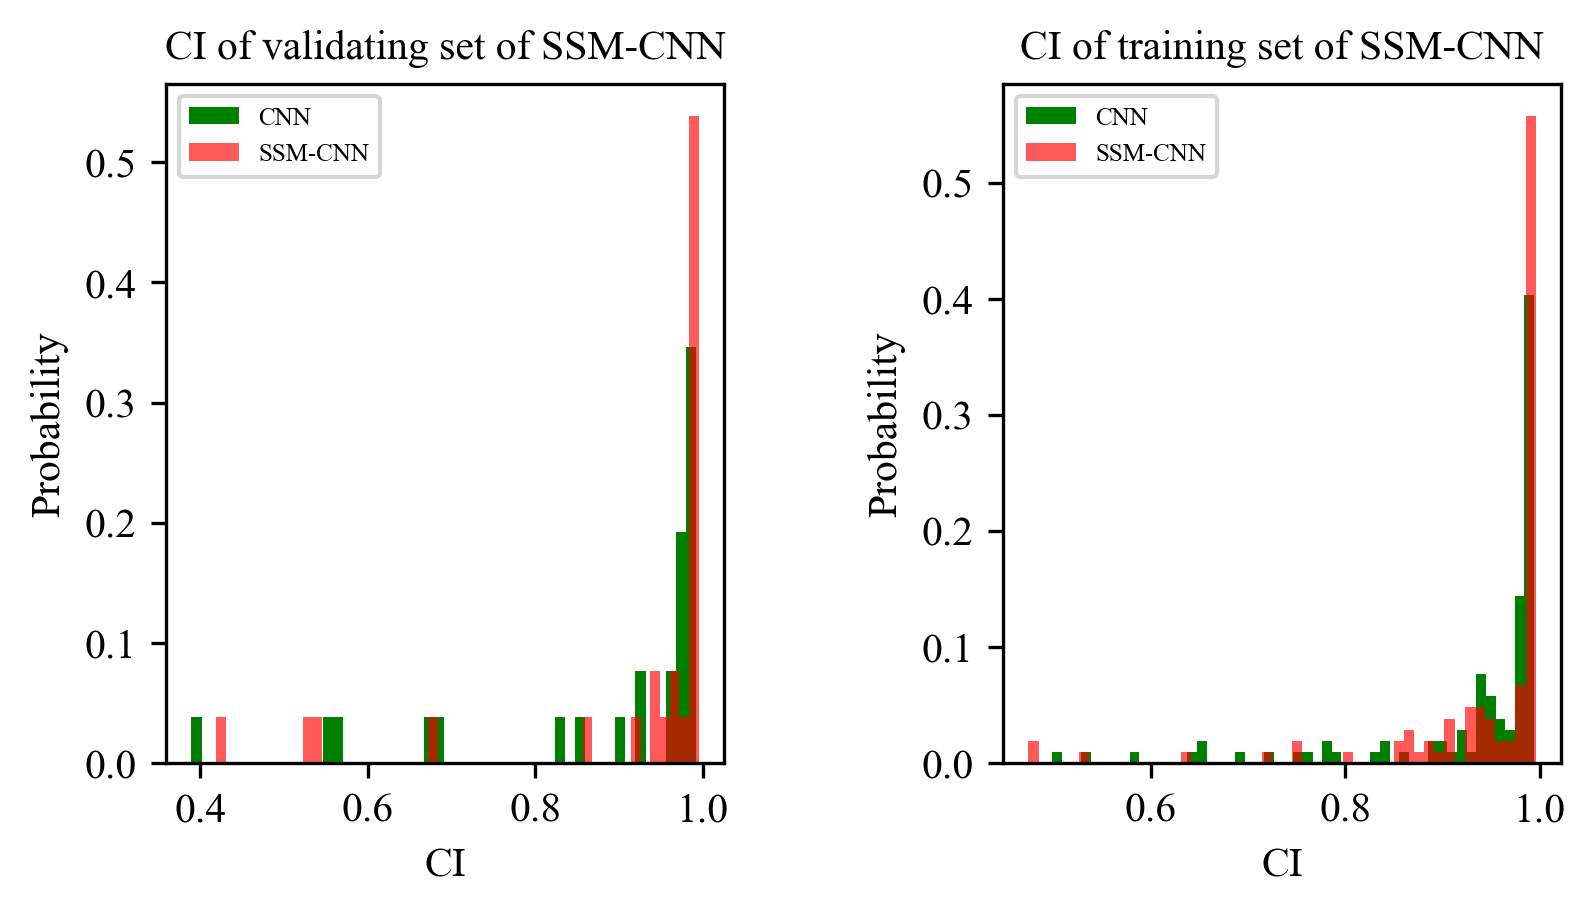

In [74]:
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

weights_exp_val=np.ones_like(ci_exp_val)/float(len(ci_exp_val))
weights_exp_ssm_val=np.ones_like(ci_exp_ssm_val)/float(len(ci_exp_ssm_val))
ax1.hist(ci_exp_val,50,weights=weights_exp_val,histtype='stepfilled',facecolor='g', alpha=1,label='CNN')
ax1.hist(ci_exp_ssm_val,50,weights=weights_exp_ssm_val,histtype='stepfilled',facecolor='r', alpha=0.65,label='SSM-CNN')
ax1.set_title('CI of validating set of SSM-CNN',fontsize=10)
ax1.set_xlabel('CI')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper left',prop={'size': 6})

weights_exp_train=np.ones_like(ci_exp_train)/float(len(ci_exp_train))
weights_exp_ssm_train=np.ones_like(ci_exp_ssm_train)/float(len(ci_exp_ssm_train))
ax2.hist(ci_exp_train,50,weights=weights_exp_train,histtype='stepfilled',facecolor='g', alpha=1,label='CNN')
ax2.hist(ci_exp_ssm_train,50,weights=weights_exp_ssm_train,histtype='stepfilled',facecolor='r', alpha=0.65,label='SSM-CNN')
ax2.set_title('CI of training set of SSM-CNN',fontsize=10)
ax2.set_xlabel('CI')
ax2.set_ylabel('Probability')
ax2.legend(loc='upper left',prop={'size': 6})

f.subplots_adjust(wspace =0.5, hspace =2)

In [ ]:
# # # # save the model in .h5
# model3.save('Exp CNN V1.h5')
# model4.save('Exp SSM-CNN V1.h5')

In [185]:
def plot_fft(ag):
    n=len(ag)
    c=0
    while 2**c<n:
        c+=1
    N=2**c
    
    dt=0.005
    fn=int(1/(2*dt))
    f=np.arange(0,fn,fn/N)
    new_f=f[range(int(N/2))]
    
    Ag=np.fft.fft(ag,N)
    abs_Ag=np.abs(Ag)
    new_Ag=abs_Ag[range(int(N/2))]*2/N
    
#     plt.figure(figsize=(4,3),dpi=200)
    plt.plot(new_f,new_Ag,linewidth=0.7)
    plt.xlim([0,20])
    plt.ylim([0,0.45])
    plt.xlabel('frequency (Hz)',fontsize=8,weight='normal')
    plt.ylabel('amplitude',fontsize=8,weight='normal')

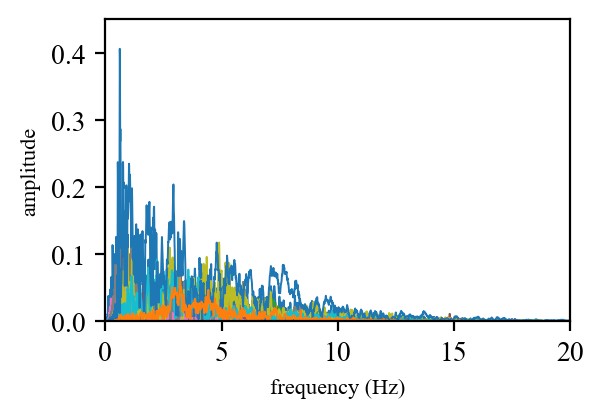

In [186]:
plt.figure(figsize=(3,2),dpi=200)

for i in range(12):
    ag=ch01[i,:]
    plot_fft(ag)

In [187]:
def plot_hist(ag):

    t0=np.arange(0,54,0.005)
    plt.plot(t0,ag,linewidth=0.7)
    plt.xlim([0,54])
#     plt.ylim([0,0.45])
    plt.xlabel('t (s)',fontsize=8,weight='normal')
    plt.ylabel('Acceleration (m/$\mathregular{s^2}$)',fontsize=8,weight='normal')


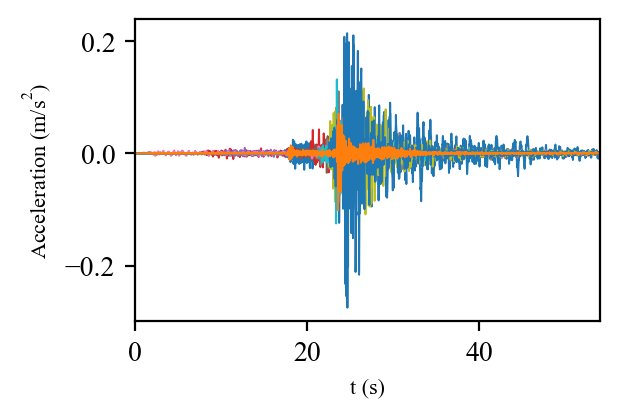

In [191]:
plt.figure(figsize=(3,2),dpi=200)

for i in range(12):
    ag=ch01[i,:]*0.01
    plot_hist(ag)

In [194]:
import statistics
# This function is to get the variance of each input seismic input, a row 

def get_variance (x):
    var=np.zeros(len(x))
    for i in range(len(x)):
        var[i]=statistics.variance(x[i,:])
    return var
# x is a matrix with a dimension of (signal_length, sample_numbers)

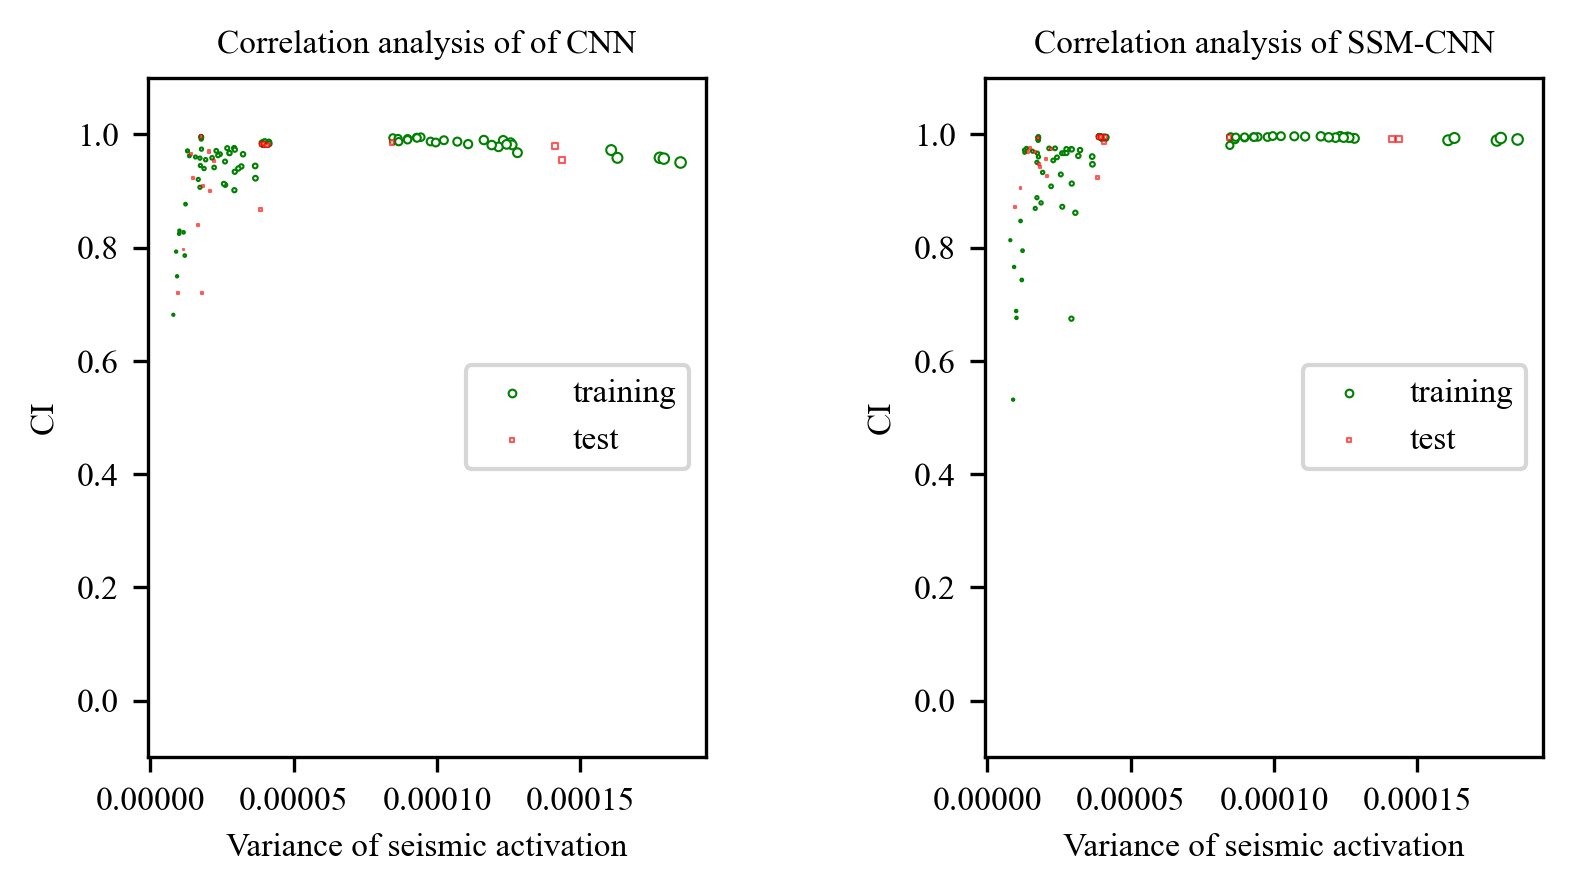

In [214]:
# To plot the scatter plot between  CI index and corresponding variance of activated seismic input 

plt.rcParams['font.size'] = 8
f = plt.figure(figsize=(6,3),dpi=300)

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

var_train=get_variance(X_exp_train)
var_test=get_variance(X_exp_val)
area_train=var_train*35000 # to control the circle dimension of scatter marker
area_test=var_test*15000
ax1.scatter(var_train,ci_exp_train,s=area_train,color='w', edgecolors='g',linewidths=0.5, alpha=1,label='training')
ax1.scatter(var_test,ci_exp_val,s=area_test,color='w', edgecolors='r',linewidths=0.5,marker='s', alpha=0.65,label='test')
ax1.legend(loc='center right',prop={'size': 8})
ax1.set_ylim([-0.1,1.1])
ax1.set_xlabel('Variance of seismic activation')
ax1.set_ylabel('CI')
ax1.set_title('Correlation analysis of of CNN',fontsize=8)

var_ssm_train=get_variance(X_exp_train)
var_ssm_test=get_variance(X_exp_val)
area_ssm_train=var_ssm_train*35000 # to control the circle dimension of scatter marker
area_ssm_test=var_ssm_test*15000
ax2.scatter(var_ssm_train,ci_exp_ssm_train,s=area_ssm_train,color='w', edgecolors='g',linewidths=0.5, alpha=1,label='training')
ax2.scatter(var_ssm_test,ci_exp_ssm_val,s=area_ssm_test,color='w', edgecolors='r',linewidths=0.5,marker='s', alpha=0.65,label='test')
ax2.legend(loc='center right',prop={'size': 8})
ax2.set_ylim([-0.1,1.1])
ax2.set_xlabel('Variance of seismic activation')
ax2.set_ylabel('CI')
ax2.set_title('Correlation analysis of SSM-CNN',fontsize=8)

f.subplots_adjust(wspace =0.5, hspace =2)